# The impact of the Covid-19 crisis on international risk sharing - R codes

 This Notebook contains all codes necessary to reproduce the tables and figures in the thesis

### General Set-up

In [1]:
rm(list=ls())
options(warn=-1)
output='text'
# please adjust path to 'MA_rep' on your machine ##user
path<-'/'

In [2]:
# load / install required packages 

# install.packages("readxl")
# install.packages('car')
# install.packages('multiwayvcov')
# install.packages("lmtest")
# install.packages("broom")
# install.packages('stargazer')
# install.packages('vars')
# install.packages("PerformanceAnalytics")
# install.packages('sessioninfo')

library(readxl)
library(car)
library(multiwayvcov)
library(lmtest)
library(broom)
library(sandwich)
library(stargazer)
library(vars)
library(PerformanceAnalytics)
library(sessioninfo)

# get session info

sessionInfo()

Loading required package: carData

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 


Loading required package: MASS

Loading required package: strucchange

Loading required package: urca

Loading required package: xts


Attaching package: 'PerformanceAnalytics'


The following object is masked from 'package:graphics':

    legend




R version 3.6.1 (2019-07-05)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19042)

Matrix products: default

locale:
[1] LC_COLLATE=English_Germany.1252  LC_CTYPE=English_Germany.1252   
[3] LC_MONETARY=English_Germany.1252 LC_NUMERIC=C                    
[5] LC_TIME=English_Germany.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] sessioninfo_1.1.1          PerformanceAnalytics_2.0.4
 [3] xts_0.12.1                 vars_1.5-3                
 [5] urca_1.3-0                 strucchange_1.5-2         
 [7] MASS_7.3-51.6              ggplot2_3.3.0             
 [9] stargazer_5.2.2            sandwich_3.0-0            
[11] broom_0.7.6                lmtest_0.9-38             
[13] zoo_1.8-9                  multiwayvcov_1.2.3        
[15] car_3.0-10                 carData_3.0-4             
[17] readxl_1.3.1              

loaded via a namespace (and not attached):


In [3]:
# define helping routines

log.diff<-function(vec){ # get log growth rates
  vec=log(t(vec))
  return(vec[-1]-vec[-length(vec)])
}

geom<-function(x){ # geometric mean
  n=length(x)
  return(prod((1+x))^(1/n))-1
}

to.num<-function(x){ # get any object to numeric format
  x=data.frame(x)
  h<-matrix(nrow = nrow(x),ncol = ncol(x))
  for(i in 1:nrow(x)){
    for(j in 1:ncol(x)){
      h[i,j]=as.numeric(x[i,j])
    }
  }
  return(h)
}

year<-function(vec,start=1,sq=1){ # get from quarterly count to years
  vec=vec+sq-1
  return(vec/4-(vec%%4)/4+start)
}

E<-function(A,dx,r){ # helping function to calculate permanent component
  A=A/(1+r)
  return(c(1,-1,0)%*%A%*%solve(diag(3)-A)%*%dx)
}

to.year<-function(vec){ # aggregates quarterly data on year level
  n=length(vec)
  stopifnot((n/4)%%1==0) # all quarters for each year have to be in the data
  res=c()
  for (t in 1:(n/4)) {
    res[t]=sum(vec[(4*t-3):(4*t)])
  }
  return(res)
}

### read in data - european sample

In [4]:
# select sample and weighting

wls=0 # 1 implies weighting by GDP ##user
sel=c(2,3,7,8,9,10,11,12,14,15,16,18,19) # subset here ##user
codes=c('as','au','be','br','cd','cz','dn','fn','fr','ge','gr','it','jp','nl','nw','po','ru','sp','sw','tk','uk','us')[sel]
names=c('Australia','Austria','Belgium','Brazil','Canada','Czech Republic','Denmark','Finland','France','Germany','Greece','Italy','Japan','Netherlands','Norway','Portugal','Russian Federation','Spain','Sweden','Turkey','United Kingdom','United States')[sel]
obs=length(names)

In [5]:
# un-data B1GQ_S1, P3_S1 

z=0
for(k in codes){
  z=z+1
  assign(k,read_xlsx(paste(path,'MA_rep/un_data/',names[z],'.xlsx',sep = '')))
}

# eurostat raw income data

disp_raw<-read_xlsx(paste(path,'MA_rep/eurostat_data/NASQ_10_NF_TR__custom_9241181620470056331','.xlsx',sep = ''),sheet = 3)

# eurostat data to get deflator

raw_defl<-read_xlsx(paste(path,'MA_rep/eurostat_data/NAMQ_10_GDP__custom_9282471620593160149','.xlsx',sep = ''),sheet = 3)

# eurostat nat income data

natinc_raw<-read_xlsx(paste(path,'MA_rep/eurostat_data/NASQ_10_NF_TR__custom_9524881621008698098','.xlsx',sep = ''),sheet = 3)

# eurostat data cross boarder work 

cb_raw<-read_xlsx(paste(path,'MA_rep/eurostat_data/LFSQ_EGAN__custom_10069781622282993343','.xlsx',sep = ''),sheet = 3)[-c(1:10,37:41),]

# eurostat international investment data

intinv_raw<-read_xlsx(paste(path,'MA_rep/eurostat_data/BOP_IIP6_Q__custom_10998231624869611973','.xlsx',sep = ''),sheet = 3)

# Oxford Covid-19 Government Response Tracker

mc_raw<-read_xlsx(paste(path,'MA_rep/OxCGRT_data/OxCGRT_timeseries_all','.xlsx',sep = ''),sheet = 1) # restrictions
ps_raw<-read_xlsx(paste(path,'MA_rep/OxCGRT_data/OxCGRT_timeseries_all','.xlsx',sep = ''),sheet = 4) # policy support
sh_raw<-read_xlsx(paste(path,'MA_rep/OxCGRT_data/OxCGRT_timeseries_all','.xlsx',sep = ''),sheet = 'c6_stay_at_home_requirements') # stay at home requirements
dcb_raw<-read_xlsx(paste(path,'MA_rep/OxCGRT_data/OxCGRT_timeseries_all','.xlsx',sep = ''),sheet = 'c8_internationaltravel') # movement restrictions

# data to get incidence levels eurostat and OxCGRT

ic_raw<-read_xlsx(paste(path,'MA_rep/OxCGRT_data/OxCGRT_timeseries_all','.xlsx',sep = ''),sheet = 'confirmed_cases') # confirmed cases
pop_raw<-read_xlsx(paste(path,'MA_rep/eurostat_data/DEMO_PJAN$DEFAULTVIEW1623014373650','.xlsx',sep = ''),sheet = 3) # population as of 01/01/2019 - pre covid such that deaths do not influece incidence 

New names:
* `` -> ...2

New names:
* `` -> ...2

New names:
* `` -> ...2

New names:
* `` -> ...2

New names:
* `` -> ...2

New names:
* `` -> ...2

New names:
* `` -> ...2

New names:
* `` -> ...2

New names:
* `` -> ...2

New names:
* `` -> ...2

New names:
* `` -> ...2

New names:
* `` -> ...2

New names:
* `` -> ...2

New names:
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* `` -> ...6
* ...

New names:
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* `` -> ...6
* ...

New names:
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* `` -> ...6
* ...

New names:
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* `` -> ...6
* ...

New names:
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* `` -> ...6
* ...

New names:
* `` -> ...2
* `` -> ...3



### get 'tilde' variables and put everything together in a data frame

In [6]:
################################## get y,c and i 'tilde' ####################################################

row_gdp='Gross domestic product at market prices [B1GQ_S1]'
row_con='Final consumption expenditure [P3_S1]'

gdp_tot=rep(0,60)
con_tot=rep(0,60)

for (i in codes) { # extract relevant variables
  assign(paste("gdp",i,sep="_"),get(i)[get(i)$Indicator==row_gdp & is.na(get(i)$`Reference year`)==0,][1,][7:66])
  assign(paste("con",i,sep="_"),get(i)[get(i)$Indicator==row_con & is.na(get(i)$`Reference year`)==0,][1,][7:66])
  gdp_tot=gdp_tot+get(paste("gdp",i,sep="_"))
  con_tot=con_tot+get(paste("con",i,sep="_")) 
}

for (i in c(codes,'tot')){ # get log growth rates
  assign(paste("gdp",i,sep="_"),log.diff(get(paste("gdp",i,sep="_"))))
  assign(paste("con",i,sep="_"),log.diff(get(paste("con",i,sep="_"))))
}

for (i in codes){ # get tilde
  assign(paste("gdp",i,sep="_"),get(paste("gdp",i,sep="_"))-gdp_tot)
  assign(paste("con",i,sep="_"),get(paste("con",i,sep="_"))-con_tot)
}

################################## get disp inc 'tilde'  ####################################################

disp<-disp_raw[disp_raw$`Data extracted on 08/05/2021 12:34:19 from [ESTAT]` %in% c(names,'TIME'),]
cols=c(1)
for(t in 2006:2020){
  cols=c(cols,grep(toString(t), disp[1,]))
}
disp=disp[,cols]
inc_tot=rep(0,60)
z=0
bad=c() # verctor for index of countries with unsufficient data
for(k in names){
  z=z+1
  c=codes[z]
  tmp=disp[disp[,1]==k,][,-1]
  assign(paste("inc",c,sep="_"),to.num(tmp[2,])-to.num(tmp[1,]))
  if(is.na(sum(get(paste("inc",c,sep="_"))))==0){
  inc_tot=inc_tot+get(paste("inc",c,sep="_"))
  }
  else{bad=c(bad,z)}
}

if(length(bad)!=0){
names=names[-bad]
codes=codes[-bad]
obs=length(codes)}

for (i in c(codes,'tot')){ # get log growth rates
  assign(paste("inc",i,sep="_"),log.diff(get(paste("inc",i,sep="_"))))
}

#begin deflate income # check this logic, save alternaticve nominal - ral growth = inflation # checked works fine
defl<-raw_defl[raw_defl$`Data extracted on 09/05/2021 23:13:09 from [ESTAT]` %in% c('TIME','UNIT (Labels)',names),]
col=c(1,grep('20',defl[1,]))
defl<-to.num(defl[,col][-(1:2),-1])
tot.defl<-colSums(defl)
defl=defl[,seq(1,length(defl[1,]),2)]/defl[,seq(2,length(defl[1,]),2)]
tot.defl=tot.defl[seq(1,length(tot.defl),2)]/tot.defl[seq(2,length(tot.defl),2)]
tot.defl=log.diff(tot.defl)
z=0
for(i in codes){
  z=z+1
  assign(paste("defl",i,sep="_"),log.diff(defl[z,])-tot.defl)
}
#end deflate income
for (i in codes){ # get tilde
  assign(paste("inc",i,sep="_"),get(paste("inc",i,sep="_"))-inc_tot-get(paste("defl",i,sep="_")))
}

################################# get net and gross nat income ###############################################

natinc<-natinc_raw[natinc_raw$`Data extracted on 14/05/2021 18:11:41 from [ESTAT]` %in% c(names,'TIME'),]
cols=c(1,2)
for(t in 2006:2020){
  cols=c(cols,grep(toString(t), natinc[1,]))
}
natinc=natinc[,cols]

gni_tot=log.diff(colSums(to.num(natinc[natinc$`Data extracted on 14/05/2021 18:11:41 from [ESTAT]`!='TIME' & natinc$...2=='Gross national income at market prices',-(1:2)])))
nni_tot=log.diff(colSums(to.num(natinc[natinc$`Data extracted on 14/05/2021 18:11:41 from [ESTAT]`!='TIME' & natinc$...2=='Net national income at market prices',-(1:2)])))
z=0

for(k in names){
  z=z+1
  c=codes[z]
  assign(paste("nni",c,sep="_"),log.diff(to.num(natinc[natinc$`Data extracted on 14/05/2021 18:11:41 from [ESTAT]`==k & natinc$...2=='Net national income at market prices',-(1:2)]))-nni_tot-get(paste("defl",c,sep="_")))
  assign(paste("gni",c,sep="_"),log.diff(to.num(natinc[natinc$`Data extracted on 14/05/2021 18:11:41 from [ESTAT]`==k & natinc$...2=='Gross national income at market prices',-(1:2)]))-gni_tot-get(paste("defl",c,sep="_")))
}

################################# prepare measure data #######################################################

mc<-mc_raw[mc_raw$country_name %in% names,]   # here alphabetical ordering becomes importand
mc.2020<-mc[, -grep("2021", colnames(mc))]

mc.q1<-rowMeans(mc.2020[,c(grep("Jan", colnames(mc.2020)),grep("Feb", colnames(mc.2020)),grep("Mar", colnames(mc.2020)))])
mc.q2<-rowMeans(mc.2020[,c(grep("Apr", colnames(mc.2020)),grep("May", colnames(mc.2020)),grep("Jun", colnames(mc.2020)))])
mc.q3<-rowMeans(mc.2020[,c(grep("Jul", colnames(mc.2020)),grep("Aug", colnames(mc.2020)),grep("Sep", colnames(mc.2020)))])
mc.q4<-rowMeans(mc.2020[,c(grep("Oct", colnames(mc.2020)),grep("Nov", colnames(mc.2020)),grep("Dec", colnames(mc.2020)))])

ps<-ps_raw[ps_raw$country_name %in% names,]
ps.2020<-ps[, -grep("2021", colnames(ps))]

ps.q1<-rowMeans(ps.2020[,c(grep("Jan", colnames(ps.2020)),grep("Feb", colnames(ps.2020)),grep("Mar", colnames(ps.2020)))])
ps.q2<-rowMeans(ps.2020[,c(grep("Apr", colnames(ps.2020)),grep("May", colnames(ps.2020)),grep("Jun", colnames(ps.2020)))])
ps.q3<-rowMeans(ps.2020[,c(grep("Jul", colnames(ps.2020)),grep("Aug", colnames(ps.2020)),grep("Sep", colnames(ps.2020)))])
ps.q4<-rowMeans(ps.2020[,c(grep("Oct", colnames(ps.2020)),grep("Nov", colnames(ps.2020)),grep("Dec", colnames(ps.2020)))])

################################ prepare incidence data #######################################################

cutoffs<-c('country_name','31Mar2020','30Jun2020','30Sep2020','31Dec2020')
ic_raw<-ic_raw[,names(ic_raw) %in% cutoffs]
ic_raw[,-(1:2)]<-ic_raw[,-(1:2)]-ic_raw[,-c(1,5)]

ic_raw=ic_raw[c(t(ic_raw[,1])) %in% names,]
pop_raw=pop_raw[c(t(pop_raw[,1])) %in% names,1:2]
ic_meet=ic_raw

pop=c()
k=0
for (i in names) {
  k=k+1
  l=codes[k]
  assign(paste("ic",l,sep="_"),c(rep(0,55),to.num(ic_meet[ic_meet[,1]==i,-1])/to.num(pop_raw[pop_raw[,1]==i,-1])[1,1]))
  pop[k]=to.num(pop_raw[pop_raw[,1]==i,-1])[1,1]
}

############################## put everything into a df #######################################################

t=length(get(paste('gdp',codes[1],sep='_')))
dta<-data.frame(pit=1:t,'nat'=rep(codes[1],t),'pop'=rep(pop[1],t),'con'=get(paste('con',codes[1],sep='_')),'inc'=get(paste('inc',codes[1],sep='_')),'gdp'=get(paste('gdp',codes[1],sep='_')),'ic'=get(paste('ic',codes[1],sep='_')),'mc'=rep(0,t),'ps'=rep(0,t),'nni'=get(paste('nni',codes[1],sep = '_')),'gni'=get(paste('gni',codes[1],sep = '_')))

k=1
for (i in codes[2:obs]) {
  k=k+1
  tmp=data.frame(pit=1:t,'nat'=rep(i,t),'pop'=rep(pop[k],t),'con'=get(paste('con',i,sep='_')),'inc'=get(paste('inc',i,sep='_')),'gdp'=get(paste('gdp',i,sep='_')),'ic'=get(paste('ic',i,sep='_')),'mc'=rep(0,t),'ps'=rep(0,t),'nni'=get(paste('nni',i,sep = '_')),'gni'=get(paste('gni',i,sep = '_')))
  dta=rbind(dta,tmp)
}

k=0
for (i in codes[1:obs]) {
  k=k+1
  dta[dta$nat==i & dta$pit==56,'mc']=mc.q1[k]
  dta[dta$nat==i & dta$pit==57,'mc']=mc.q2[k]
  dta[dta$nat==i & dta$pit==58,'mc']=mc.q3[k]
  dta[dta$nat==i & dta$pit==59,'mc']=mc.q4[k]
  dta[dta$nat==i & dta$pit==56,'ps']=ps.q1[k]
  dta[dta$nat==i & dta$pit==57,'ps']=ps.q2[k]
  dta[dta$nat==i & dta$pit==58,'ps']=ps.q3[k]
  dta[dta$nat==i & dta$pit==59,'ps']=ps.q4[k]

}

################################### add border closings (share of days) #####################

dcb<-dcb_raw[dcb_raw$country_name %in% names,]   # here alphabetical ordering becomes importand
dcb.2020<-dcb[, -grep("2021", colnames(dcb))]

dcb.q1<-rowMeans(dcb.2020[,c(grep("Jan", colnames(dcb.2020)),grep("Feb", colnames(dcb.2020)),grep("Mar", colnames(dcb.2020)))]==4)
dcb.q2<-rowMeans(dcb.2020[,c(grep("Apr", colnames(dcb.2020)),grep("May", colnames(dcb.2020)),grep("Jun", colnames(dcb.2020)))]==4)
dcb.q3<-rowMeans(dcb.2020[,c(grep("Jul", colnames(dcb.2020)),grep("Aug", colnames(dcb.2020)),grep("Sep", colnames(dcb.2020)))]==4)
dcb.q4<-rowMeans(dcb.2020[,c(grep("Oct", colnames(dcb.2020)),grep("Nov", colnames(dcb.2020)),grep("Dec", colnames(dcb.2020)))]==4)

dta$dcb=0

k=0
for (i in codes[1:obs]) {
  k=k+1
  dta[dta$nat==i & dta$pit==56,'dcb']=dcb.q1[k]
  dta[dta$nat==i & dta$pit==57,'dcb']=dcb.q2[k]
  dta[dta$nat==i & dta$pit==58,'dcb']=dcb.q3[k]
  dta[dta$nat==i & dta$pit==59,'dcb']=dcb.q4[k]
}

################################### add stay at home requirements (share of days) ###########

sh<-sh_raw[sh_raw$country_name %in% names,]   # here alphabetical ordering becomes important
sh.2020<-sh[, -grep("2021", colnames(sh))]

sh.q1<-rowMeans(sh.2020[,c(grep("Jan", colnames(sh.2020)),grep("Feb", colnames(sh.2020)),grep("Mar", colnames(sh.2020)))]>1)
sh.q2<-rowMeans(sh.2020[,c(grep("Apr", colnames(sh.2020)),grep("May", colnames(sh.2020)),grep("Jun", colnames(sh.2020)))]>1)
sh.q3<-rowMeans(sh.2020[,c(grep("Jul", colnames(sh.2020)),grep("Aug", colnames(sh.2020)),grep("Sep", colnames(sh.2020)))]>1)
sh.q4<-rowMeans(sh.2020[,c(grep("Oct", colnames(sh.2020)),grep("Nov", colnames(sh.2020)),grep("Dec", colnames(sh.2020)))]>1)

dta$sh=0

k=0
for (i in codes[1:obs]) {
  k=k+1
  dta[dta$nat==i & dta$pit==56,'sh']=sh.q1[k]
  dta[dta$nat==i & dta$pit==57,'sh']=sh.q2[k]
  dta[dta$nat==i & dta$pit==58,'sh']=sh.q3[k]
  dta[dta$nat==i & dta$pit==59,'sh']=sh.q4[k]
}

################################### add years for clustering ################################

dta$year=year(dta$pit,start = 2006)

################################### add seansonal and calendar adjusted GDP for WLS #########

for (i in codes) { # gdp levels seasonal and calendar adjusted
  assign(paste("w.GDP",i,sep="_"),to.num(get(i)[get(i)$Indicator==row_gdp & is.na(get(i)$`Reference year`)==0,][2,][7:66]))
}

dta$GDP=0

for (i in 1:nrow(dta)) {
  dta$GDP[i]=get(paste('w.GDP',dta$nat[i],sep = '_'))[dta$pit[i]+1]
}

if(wls==0){
  dta$Gdp=dta$GDP
  dta$GDP=1
}

# show head of 2020 subset of df

head(dta[dta$pit>55,])

,pit,nat,pop,con,inc,gdp,ic,mc,ps,nni,gni,dcb,sh,year,GDP,Gdp
,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
56,56,au,8858775,-0.022121075,-0.05709470,-0.023567000,0.0011491431,18.76231,14.14835,-0.05718963,-0.047568705,0.0000000,0.1758242,2020,1,81980
57,57,au,8858775,0.004878134,0.04242925,-0.019640247,0.0008563261,63.13538,87.50000,0.04187343,0.040232105,0.0000000,0.3296703,2020,1,73186
58,58,au,8858775,0.046772755,-0.01098804,0.059284649,0.0030531309,38.04217,87.50000,-0.01366692,-0.016330370,0.0000000,0.0000000,2020,1,81818
59,59,au,8858775,-0.064857309,-0.01406840,-0.043663617,0.0356710719,68.18804,96.46739,-0.01052892,-0.005505626,0.0000000,0.8260870,2020,1,79603
115,56,be,11455519,-0.062175131,-0.05873553,-0.045979884,0.0011151830,20.61429,18.13187,-0.05601728,-0.050937996,0.1318681,0.1538462,2020,1,100483
116,57,be,11455519,0.015608442,0.01135441,-0.003927819,0.0042470359,71.75297,87.50000,0.01312232,0.014637664,0.3736264,0.7472527,2020,1,88608


### Figure 4: Correlation matrix for european sample

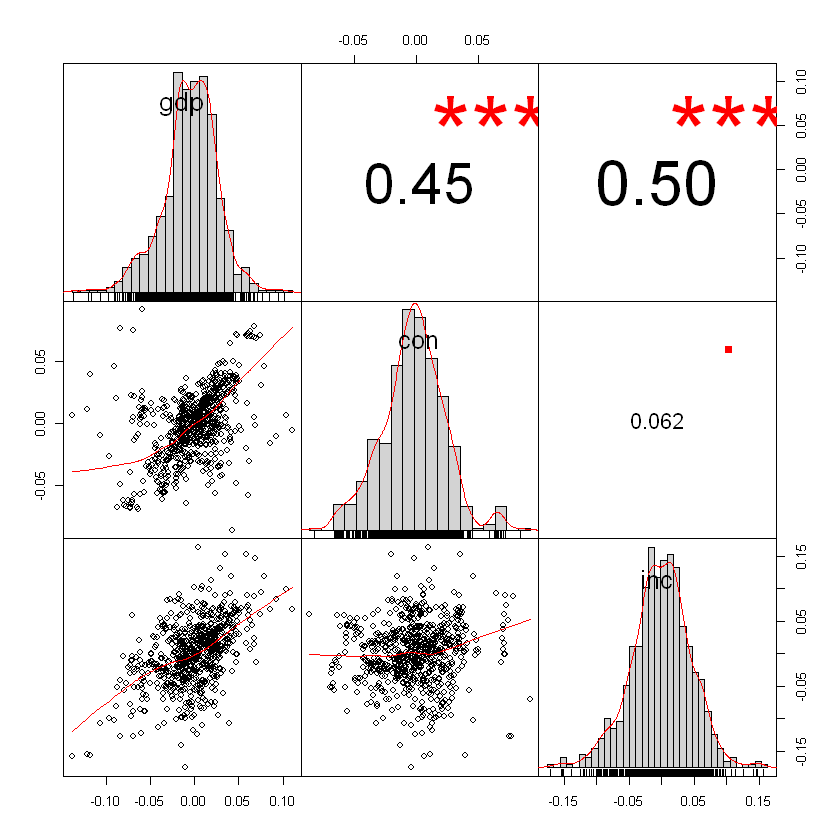

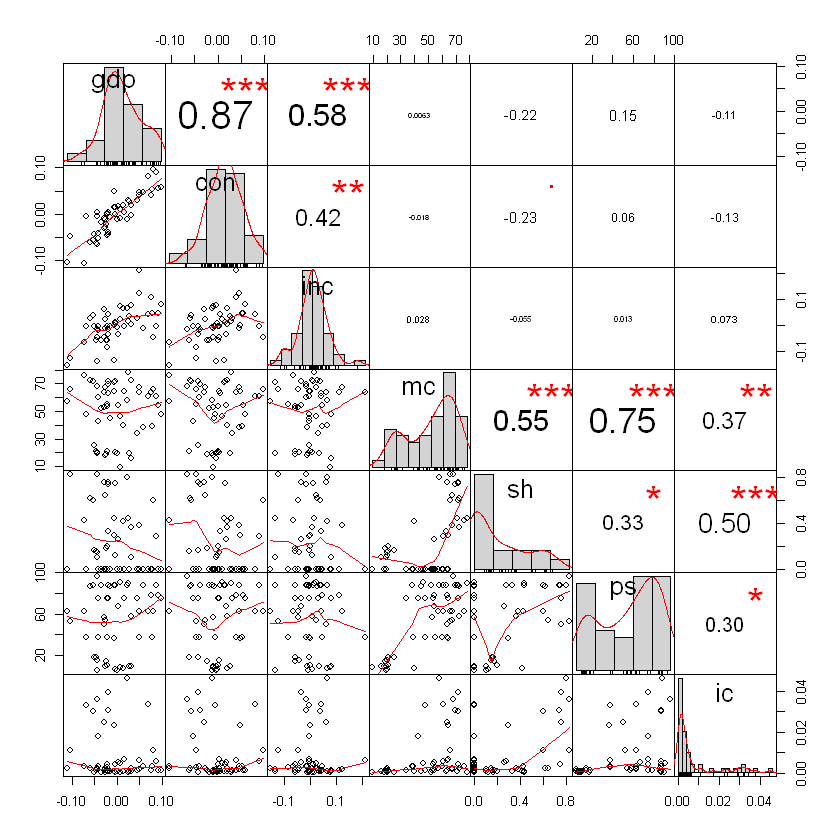

In [7]:
# pre 2020
chart.Correlation(dta[dta$pit<=55,c('gdp','con','inc')])

# 2020
chart.Correlation(dta[dta$pit>55,c('gdp','con','inc','mc','sh','ps','ic')])

### Table 1: OLS: Y = country fixed effects + GDP


In [8]:
r.s.c.1<-glm(con~factor(nat)+gdp,data = dta,weights=dta$GDP)
r.s.i.1<-glm(inc~factor(nat)+gdp,data = dta,weights=dta$GDP)
Consumption<-coeftest(r.s.c.1,vcovCL,cluster=dta[,c('nat','year')])
Disposable_Income<-coeftest(r.s.i.1,vcovCL,cluster=dta[,c('nat','year')])
stargazer(Consumption,Disposable_Income,type = output,title = 'OLS: Y = country fixed effects + GDP',style = 'qje',omit = 'factor',omit.labels = ' Country fixed effects',column.labels = c('Y=Consumption','Y=Disposable Income'))


OLS: Y = country fixed effects + GDP
                                                             
                         Y=Consumption    Y=Disposable Income
                              (1)                 (2)        
-------------------------------------------------------------
gdp                         0.427**            0.746***      
                            (0.196)             (0.137)      
                                                             
Constant                   -0.001***           0.001***      
                           (0.0002)            (0.0004)      
                                                             
Country fixed effects         Yes                 Yes        
Notes:                 ***Significant at the 1 percent level.
                        **Significant at the 5 percent level.
                        *Significant at the 10 percent level.


### Table 2: OLS: Y = country fixed effects + incidence + GDP * covid measures * policy support

In [9]:
r.i.c.1<-glm(con~factor(nat)+gdp+ic+mc*gdp*ps,data = dta,weights=dta$GDP)
r.i.i.1<-glm(inc~factor(nat)+gdp+ic+mc*gdp*ps,data = dta,weights=dta$GDP)
Consumption<-coeftest(r.i.c.1,vcovCL,cluster=dta[,c('nat','year')])
Disposable_Income<-coeftest(r.i.i.1,vcovCL,cluster=dta[,c('nat','year')])
stargazer(Consumption,Disposable_Income,type = output,title = 'OLS: Y = country fixed effects + incidence + GDP * covid measures * policy support',style = 'qje',omit = 'factor',omit.labels = ' Country fixed effects',column.labels = c('Y=Consumption','Y=Disposable Income'))


OLS: Y = country fixed effects + incidence + GDP * covid measures * policy support
                                                             
                         Y=Consumption    Y=Disposable Income
                              (1)                 (2)        
-------------------------------------------------------------
gdp                         0.369*             0.744***      
                            (0.206)             (0.157)      
                                                             
ic                          -0.054             0.727***      
                            (0.101)             (0.161)      
                                                             
mc                         0.0002***           0.001***      
                           (0.00003)           (0.0001)      
                                                             
ps                         -0.00004            -0.0003**     
                           (0.0001)            (

### Figure 5 \& 6

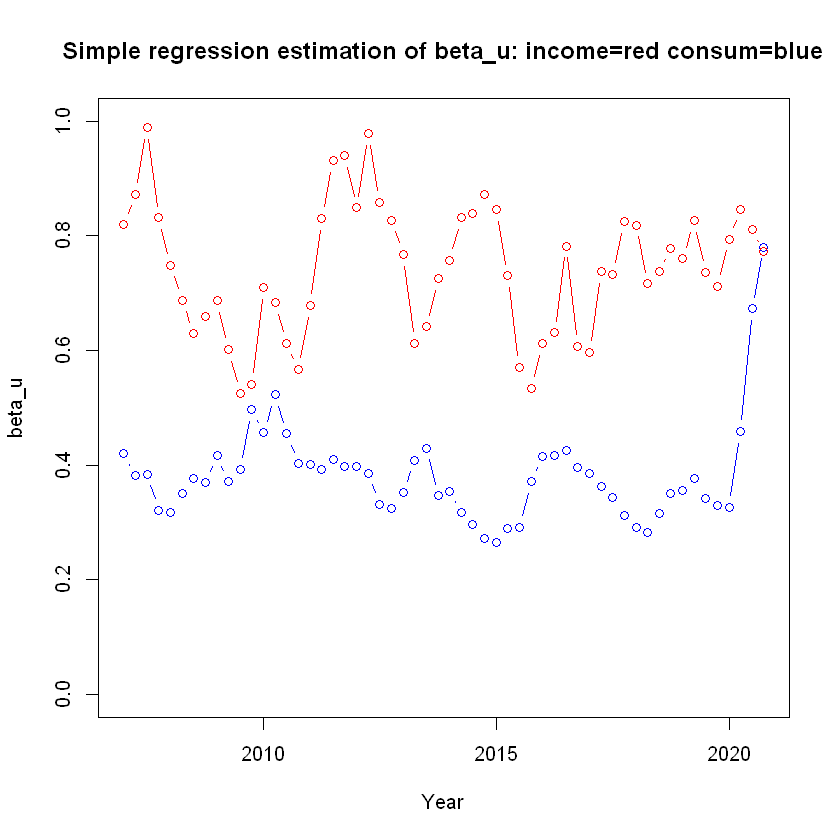

In [10]:
b.con.1=c()
for(i in 4:59){
  reg.con.1<-glm(con~factor(nat)+gdp,data = dta[dta$pit %in% (i-3):i,],weights=dta[dta$pit %in% (i-3):i,]$GDP)
  b.con.1[i-3]=reg.con.1$coefficients['gdp']
  assign(paste('r.ds.c',i-3,sep = '.'),reg.con.1)
}

b.inc.1=c()
for(i in 4:59){
  reg.inc.1<-glm(inc~factor(nat)+gdp,data = dta[dta$pit %in% (i-3):i,],weights=dta[dta$pit %in% (i-3):i,]$GDP)
  b.inc.1[i-3]=reg.inc.1$coefficients['gdp']
  assign(paste('r.ds.i',i-3,sep = '.'),reg.inc.1)
}

plot(seq(as.Date("2007/1/1"), as.Date("2020/12/31"), by = "quarter"),b.con.1,type = 'b',ylab = 'beta_u',xlab = 'Year',ylim = c(0,1),col = 'blue')
lines(seq(as.Date("2007/1/1"), as.Date("2020/12/31"), by = "quarter"),b.inc.1,type = 'b',ylab = 'beta_u',xlab = 'Year',ylim = c(0,1),col = 'red')
title('Simple regression estimation of beta_u: income=red consum=blue')


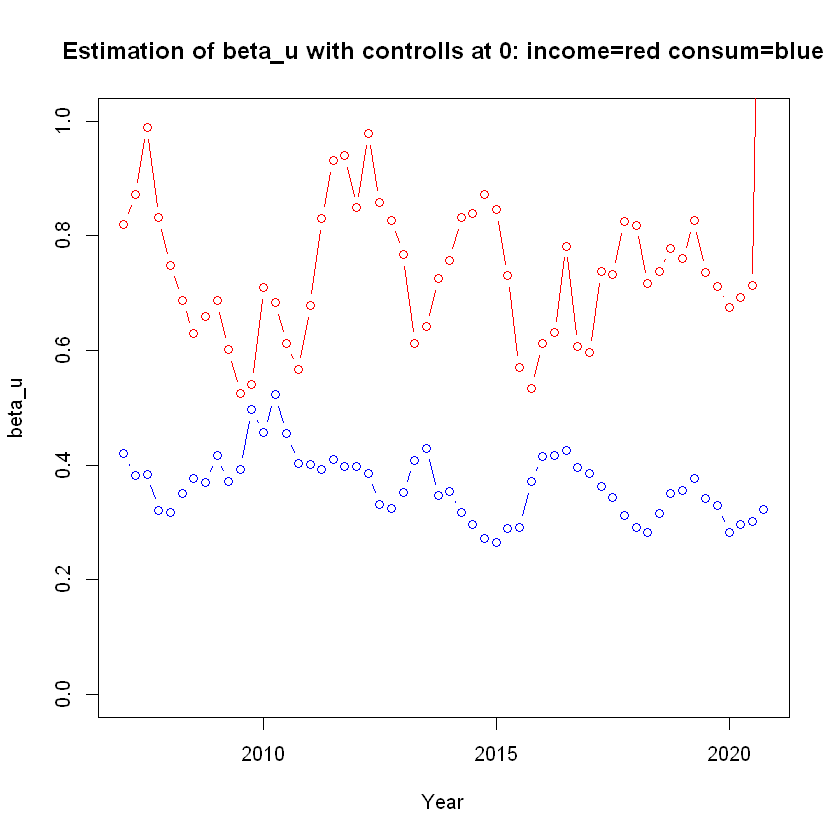

In [11]:
b.con.6=c()
for(i in 4:59){
  reg.con.6<-glm(con~factor(nat)+gdp*ps*mc+ic,data = dta[dta$pit %in% (i-3):i,],weights=dta[dta$pit %in% (i-3):i,]$GDP)
  b.con.6[i-3]=reg.con.6$coefficients['gdp']
  assign(paste('r.di.c',i-3,sep = '.'),reg.con.6)
}

b.inc.6=c()
for(i in 4:59){
  reg.inc.6<-glm(inc~factor(nat)+gdp*ps*mc+ic,data = dta[dta$pit %in% (i-3):i,],weights=dta[dta$pit %in% (i-3):i,]$GDP)
  b.inc.6[i-3]=reg.inc.6$coefficients['gdp']
  assign(paste('r.di.i',i-3,sep = '.'),reg.inc.6)
}

plot(seq(as.Date("2007/1/1"), as.Date("2020/12/31"), by = "quarter"),b.con.6,type = 'b',ylab = 'beta_u',xlab = 'Year',ylim = c(0,1),col = 'blue')
lines(seq(as.Date("2007/1/1"), as.Date("2020/12/31"), by = "quarter"),b.inc.6,type = 'b',ylab = 'beta_u',xlab = 'Year',ylim = c(0,1),col = 'red')
title('Estimation of beta_u with controlls at 0: income=red consum=blue')


### Table 3 \& 4: OLS: Consumption \& Disposable Income  = country fixed effects + incidence + GDP * covid measures * policy support

In [12]:
# sample split based on measure/support balance

sub.dta=dta[dta$pit>55,c('pit','nat','mc','ps')]

corrs<-data.frame(sub.dta[1:4,3:4])
for(i in 2:13){
  corrs<-data.frame(corrs,sub.dta[(1+4*(i-1)):(4+4*(i-1)),3:4])
}

ratio<-rbind(names,colMeans(corrs)[seq(1,26,2)]/colMeans(corrs)[seq(2,26,2)])

subsam<-ratio[2,]>1
othsam<-ratio[2,]<=1

stargazer(coeftest(lm(con~factor(nat)+ic+gdp*mc*ps,data = dta[dta$nat %in% codes[subsam],]),vcovCL,cluster=dta[dta$nat %in% codes[subsam],][,c('nat','year')]),coeftest(lm(con~factor(nat)+ic+gdp*mc*ps,data = dta[dta$nat %in% codes[othsam],]),vcovCL,cluster=dta[dta$nat %in% codes[othsam],][,c('nat','year')]),coeftest(lm(con~factor(nat)+ic+gdp*mc*ps,data = dta[dta$nat %in% codes,]),vcovCL,cluster=dta[dta$nat %in% codes,][,c('nat','year')]),type=output,title = 'OLS: Consumption = country fixed effects + incidence + GDP * covid measures * policy support',style = 'qje',omit = 'factor',omit.labels = ' Country fixed effects',column.labels = c('high measures to support','low measures to support','all'))
stargazer(coeftest(lm(inc~factor(nat)+ic+gdp*mc*ps,data = dta[dta$nat %in% codes[subsam],]),vcovCL,cluster=dta[dta$nat %in% codes[subsam],][,c('nat','year')]),coeftest(lm(inc~factor(nat)+ic+gdp*mc*ps,data = dta[dta$nat %in% codes[othsam],]),vcovCL,cluster=dta[dta$nat %in% codes[othsam],][,c('nat','year')]),coeftest(lm(inc~factor(nat)+ic+gdp*mc*ps,data = dta[dta$nat %in% codes,]),vcovCL,cluster=dta[dta$nat %in% codes,][,c('nat','year')]),type=output,title = 'OLS: Disposable Income = country fixed effects + incidence + GDP * covid measures * policy support',style = 'qje',omit = 'factor',omit.labels = ' Country fixed effects',column.labels = c('high measures to support','low measures to support','all'))


OLS: Consumption = country fixed effects + incidence + GDP * covid measures * policy support
                                                                                
                      high measures to support low measures to support    all   
                                (1)                      (2)              (3)   
--------------------------------------------------------------------------------
ic                            0.693***                -0.916***         -0.054  
                              (0.132)                  (0.039)          (0.103) 
                                                                                
gdp                            0.488                    0.310           0.369*  
                              (0.342)                  (0.228)          (0.208) 
                                                                                
mc                           0.0001***               -0.0004***        0.0002***
               

### Table 5: OLS: Channel decomposition

In [13]:
# static point of view

s=0 # s+1 = starting point in time
f=60 # l-1 = end point in time

b=c()
bf<-glm((gdp-gni)~factor(nat)+ic+gdp*mc*ps,data = dta[dta$pit>s & dta$pit<f,],weights=dta[dta$pit>s & dta$pit<f,]$GDP)
b[1]=bf$coefficients['gdp']
bd<-glm((gni-nni)~factor(nat)+ic+gdp*mc*ps,data = dta[dta$pit>s & dta$pit<f,],weights=dta[dta$pit>s & dta$pit<f,]$GDP)
b[2]=bd$coefficients['gdp']
bt<-glm((nni-inc)~factor(nat)+ic+gdp*mc*ps,data = dta[dta$pit>s & dta$pit<f,],weights=dta[dta$pit>s & dta$pit<f,]$GDP)
b[3]=bt$coefficients['gdp']
bs<-glm((inc-con)~factor(nat)+ic+gdp*mc*ps,data = dta[dta$pit>s & dta$pit<f,],weights=dta[dta$pit>s & dta$pit<f,]$GDP)
b[4]=bs$coefficients['gdp']
bu<-glm(con~factor(nat)+ic+gdp*mc*ps,data = dta[dta$pit>s & dta$pit<f,],weights=dta[dta$pit>s & dta$pit<f,]$GDP)
b[5]=bu$coefficients['gdp']

if(sum(b)!=1){print('attention, there might happend a mistake')}

In [14]:
stargazer(coeftest(bf,vcovCL,cluster=dta[,c('nat','year')]),coeftest(bd,vcovCL,cluster=dta[,c('nat','year')]),coeftest(bt,vcovCL,cluster=dta[,c('nat','year')]),coeftest(bs,vcovCL,cluster=dta[,c('nat','year')]),coeftest(bu,vcovCL,cluster=dta[,c('nat','year')]),title = 'OLS: Channel decomposition',style = 'qje',omit = 'factor',omit.labels = ' Country fixed effects',column.labels = c('bf','bd','bt','bs','bu'),type=output)


OLS: Channel decomposition
                                                                         
                         bf         bd         bt        bs        bu    
                         (1)       (2)        (3)        (4)       (5)   
-------------------------------------------------------------------------
ic                    -0.692***   -0.027     -0.009   0.781***   -0.054  
                       (0.131)   (0.021)    (0.017)    (0.205)   (0.101) 
                                                                         
gdp                   0.398***  -0.128***    -0.014     0.376    0.369*  
                       (0.146)   (0.021)    (0.017)    (0.342)   (0.206) 
                                                                         
mc                    -0.001*** -0.0001***  -0.00002  0.0005*** 0.0002***
                      (0.0001)  (0.00001)  (0.00002)  (0.0001)  (0.00003)
                                                                         
ps        

### Figure 7 \& 8

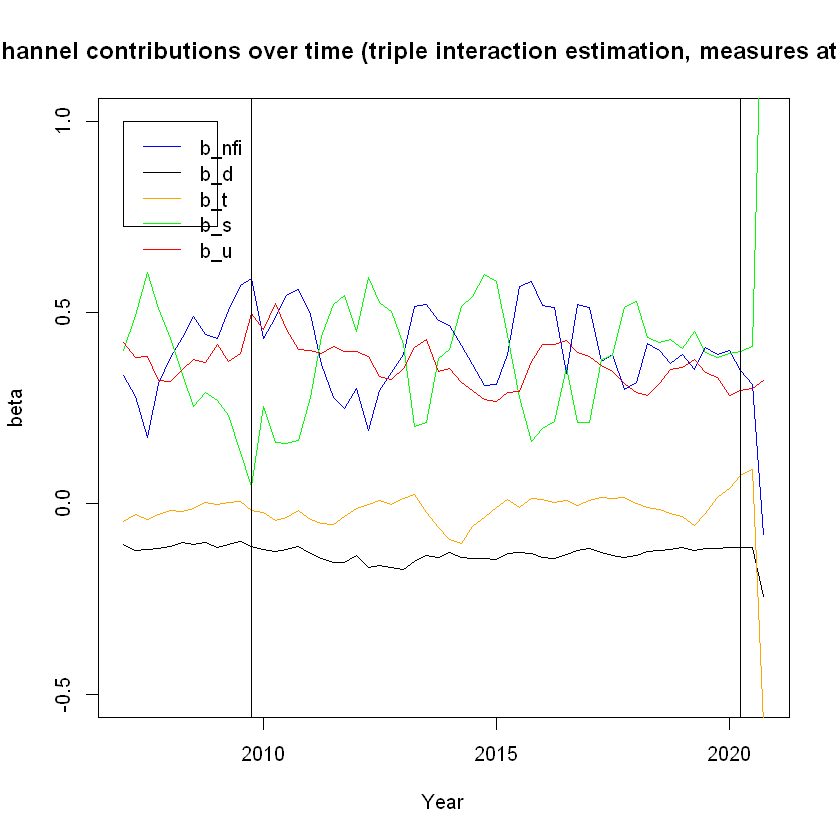

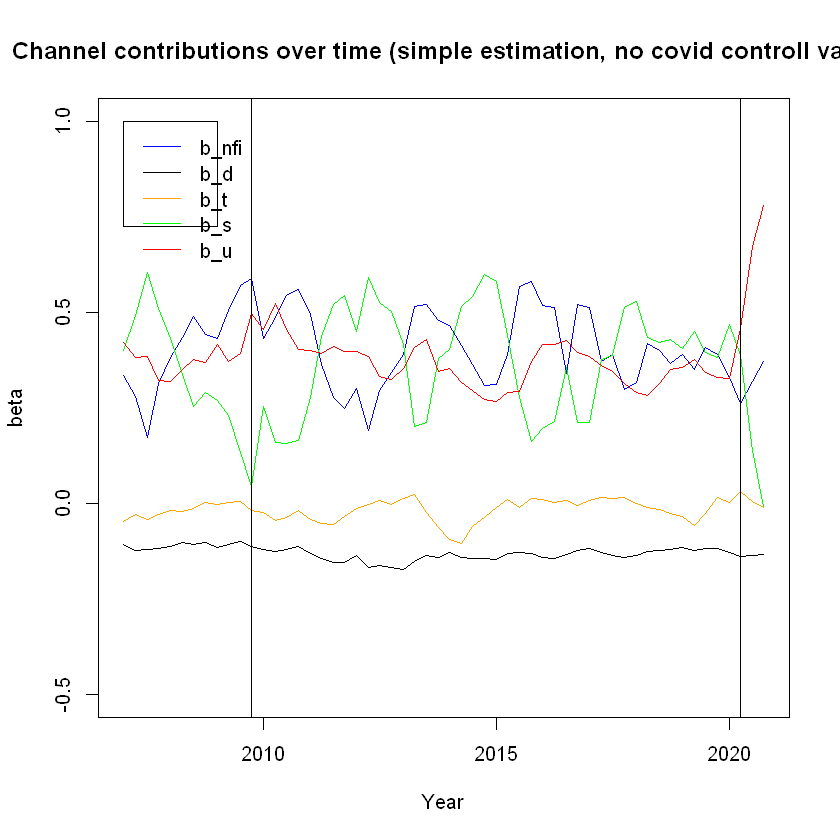

In [15]:
# dynamic point of view
B=matrix(nrow = 56,ncol = 5) # results with interactions
B.s=B                        # results with out controlls
for (t in 1:56) {
  
  s=t-1 # s+1 = starting point in time
  f=t+4 # l-1 = end point in time
 
  b=c()
  b_f<-glm((gdp-gni)~factor(nat)+ic+gdp*mc*ps,data = dta[dta$pit>s & dta$pit<f,],weights=dta[dta$pit>s & dta$pit<f,]$GDP)
  b[1]=b_f$coefficients['gdp']
  b_d<-glm((gni-nni)~factor(nat)+ic+gdp*mc*ps,data = dta[dta$pit>s & dta$pit<f,],weights=dta[dta$pit>s & dta$pit<f,]$GDP)
  b[2]=b_d$coefficients['gdp']
  b_t<-glm((nni-inc)~factor(nat)+ic+gdp*mc*ps,data = dta[dta$pit>s & dta$pit<f,],weights=dta[dta$pit>s & dta$pit<f,]$GDP)
  b[3]=b_t$coefficients['gdp']
  b_s<-glm((inc-con)~factor(nat)+ic+gdp*mc*ps,data = dta[dta$pit>s & dta$pit<f,],weights=dta[dta$pit>s & dta$pit<f,]$GDP)
  b[4]=b_s$coefficients['gdp']
  b_u<-glm(con~factor(nat)+ic+gdp*mc*ps,data = dta[dta$pit>s & dta$pit<f,],weights=dta[dta$pit>s & dta$pit<f,]$GDP)
  b[5]=b_u$coefficients['gdp']

B[t,]=b
    
  b.s=c()
  b.s_f<-glm((gdp-gni)~factor(nat)+gdp,data = dta[dta$pit>s & dta$pit<f,],weights=dta[dta$pit>s & dta$pit<f,]$GDP)
  b.s[1]=b.s_f$coefficients['gdp']  
  b.s_d<-glm((gni-nni)~factor(nat)+gdp,data = dta[dta$pit>s & dta$pit<f,],weights=dta[dta$pit>s & dta$pit<f,]$GDP)
  b.s[2]=b.s_d$coefficients['gdp']
  b.s_t<-glm((nni-inc)~factor(nat)+gdp,data = dta[dta$pit>s & dta$pit<f,],weights=dta[dta$pit>s & dta$pit<f,]$GDP)
  b.s[3]=b.s_t$coefficients['gdp']
  b.s_s<-glm((inc-con)~factor(nat)+gdp,data = dta[dta$pit>s & dta$pit<f,],weights=dta[dta$pit>s & dta$pit<f,]$GDP)
  b.s[4]=b.s_s$coefficients['gdp']
  b.s_u<-glm(con~factor(nat)+gdp,data = dta[dta$pit>s & dta$pit<f,],weights=dta[dta$pit>s & dta$pit<f,]$GDP)
  b.s[5]=b.s_u$coefficients['gdp']
  
B.s[t,]=b.s
  
}

plot(seq(as.Date("2007/1/1"), as.Date("2020/12/31"), by = "quarter"),B[,1],type = 'l',ylab = 'beta',xlab = 'Year',ylim = c(-0.5,1),col = 'blue')
lines(seq(as.Date("2007/1/1"), as.Date("2020/12/31"), by = "quarter"),B[,2],type = 'l',ylab = 'beta',xlab = 'Year',ylim = c(-0.5,1),col = 'black')
lines(seq(as.Date("2007/1/1"), as.Date("2020/12/31"), by = "quarter"),B[,3],type = 'l',ylab = 'beta',xlab = 'Year',ylim = c(-0.5,1),col = 'orange')
lines(seq(as.Date("2007/1/1"), as.Date("2020/12/31"), by = "quarter"),B[,4],type = 'l',ylab = 'beta',xlab = 'Year',ylim = c(-0.5,1),col = 'green')
lines(seq(as.Date("2007/1/1"), as.Date("2020/12/31"), by = "quarter"),B[,5],type = 'l',ylab = 'beta',xlab = 'Year',ylim = c(-0.5,1),col = 'red')
title('Channel contributions over time (triple interaction estimation, measures at zero)')
legend(x = c(as.Date("2007/1/1"), as.Date("2009/1/1")), y = c(0.725, 1),legend = c('b_nfi','b_d','b_t','b_s', 'b_u'),col = c('blue','black','orange','green','red'),lty = c(1,1))
abline(v=as.Date("2009/10/01"))
abline(v=as.Date("2020/04/01"))

plot(seq(as.Date("2007/1/1"), as.Date("2020/12/31"), by = "quarter"),B.s[,1],type = 'l',ylab = 'beta',xlab = 'Year',ylim = c(-0.5,1),col = 'blue')
lines(seq(as.Date("2007/1/1"), as.Date("2020/12/31"), by = "quarter"),B.s[,2],type = 'l',ylab = 'beta',xlab = 'Year',ylim = c(-0.5,1),col = 'black')
lines(seq(as.Date("2007/1/1"), as.Date("2020/12/31"), by = "quarter"),B.s[,3],type = 'l',ylab = 'beta',xlab = 'Year',ylim = c(-0.5,1),col = 'orange')
lines(seq(as.Date("2007/1/1"), as.Date("2020/12/31"), by = "quarter"),B.s[,4],type = 'l',ylab = 'beta',xlab = 'Year',ylim = c(-0.5,1),col = 'green')
lines(seq(as.Date("2007/1/1"), as.Date("2020/12/31"), by = "quarter"),B.s[,5],type = 'l',ylab = 'beta',xlab = 'Year',ylim = c(-0.5,1),col = 'red')
title('Channel contributions over time (simple estimation, no covid controll vars)')
legend(x = c(as.Date("2007/1/1"), as.Date("2009/1/1")), y = c(0.725, 1),legend = c('b_nfi','b_d','b_t','b_s', 'b_u'),col = c('blue','black','orange','green','red'),lty = c(1,1))
abline(v=as.Date("2009/10/01"))
abline(v=as.Date("2020/04/01"))

### Figure 9: Correlation matrix of channel contributions

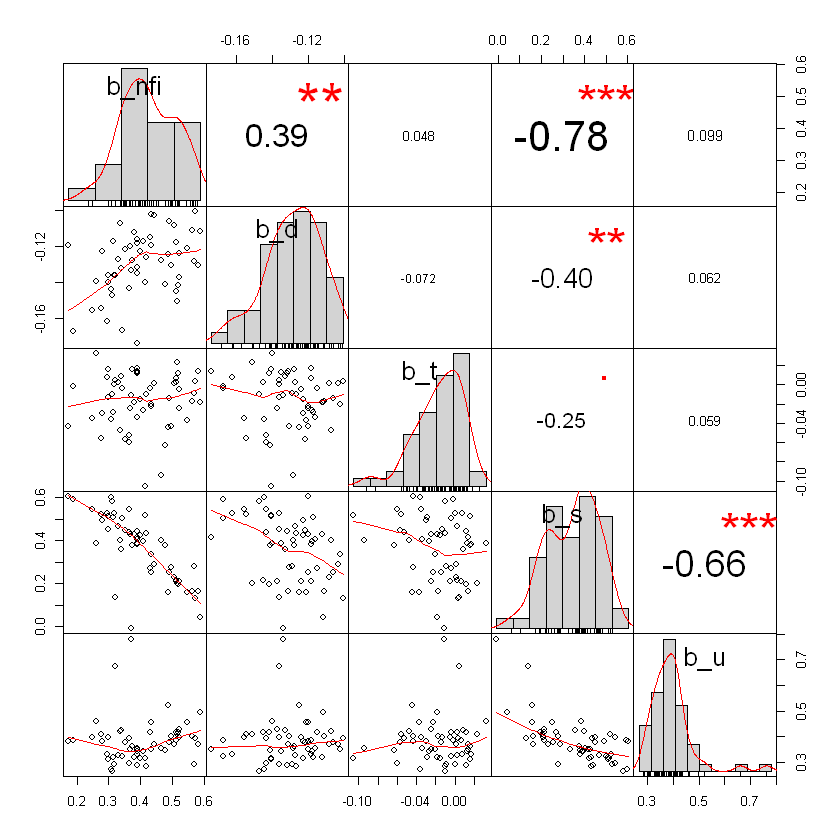

In [16]:
b.labs=c('b_nfi','b_d','b_t','b_s','b_u')
B.s=data.frame(B.s)
colnames(B.s)=b.labs
chart.Correlation(B.s)

### Table 6: OLS: (GDP - GNI) = country fixed effects + incidence + GDP * covid measures * policy support

In [17]:
# split sample based on share of foreigeners in domestic employment / with out denmark due to missing data
cb=cb_raw[,is.na(c(cb_raw[1,]))==0&c(cb_raw[1,])!='b']

cb_f=cb[cb$...2=='Foreign country',-(1:2)]
cb_t=cb[cb$...2=='Total',-(1:2)]

sfe=to.num(cb_f)/to.num(cb_t)

means_cb<-cbind(names,rowMeans(sfe))
cut_off<-mean(rowMeans(sfe[-3,]))
sel_cb<-rowMeans(sfe)>cut_off
so<-(sel_cb*1:13)[sel_cb]
so<-c(na.omit(so))
sel_cb<-rowMeans(sfe)<cut_off
st<-(sel_cb*1:13)[sel_cb]
st<-c(na.omit(st))

stargazer(coeftest(lm((gdp-gni)~factor(nat)+ic+gdp*mc*ps,data=dta[dta$nat %in% codes[so],]),vcovCL,cluster=dta[dta$nat %in% codes[so],c('nat','year')]),coeftest(lm((gdp-gni)~factor(nat)+ic+gdp*mc*ps,data=dta[dta$nat %in% codes[st],]),vcovCL,cluster=dta[dta$nat %in% codes[st],c('nat','year')]),coeftest(lm((gdp-gni)~factor(nat)+ic+gdp*mc*ps,data=dta[dta$nat %in% codes[-3],]),vcovCL,cluster=dta[dta$nat %in% codes[-3],c('nat','year')]),type=output,title = 'OLS: (GDP - GNI) = country fixed effects + incidence + GDP * covid measures * policy support',style = 'qje',omit = 'factor',omit.labels = ' Country fixed effects',column.labels = c('many foreign workers','few foreign workers','all'))


OLS: (GDP - GNI) = country fixed effects + incidence + GDP * covid measures * policy support
                                                                         
                      many foreign workers few foreign workers    all    
                              (1)                  (2)            (3)    
-------------------------------------------------------------------------
ic                          0.944***            -1.978***      -0.793*** 
                            (0.141)              (0.135)        (0.131)  
                                                                         
gdp                          0.362*             0.470***        0.402*** 
                            (0.205)              (0.161)        (0.151)  
                                                                         
mc                         -0.001***            0.0005***      -0.001*** 
                            (0.0002)            (0.0001)        (0.0001) 
                  

### Table 7: OLS: (GDP - GNI) = country fixed effects + incidence + covid measures + GDP * share of days with closed borders * policy support

In [18]:
dcb<-dcb_raw[dcb_raw$country_name %in% names,]   # here alphabetical ordering becomes importand
dcb.2020<-dcb[, -grep("2021", colnames(dcb))]

dcb.q1<-rowMeans(dcb.2020[,c(grep("Jan", colnames(dcb.2020)),grep("Feb", colnames(dcb.2020)),grep("Mar", colnames(dcb.2020)))]==4)
dcb.q2<-rowMeans(dcb.2020[,c(grep("Apr", colnames(dcb.2020)),grep("May", colnames(dcb.2020)),grep("Jun", colnames(dcb.2020)))]==4)
dcb.q3<-rowMeans(dcb.2020[,c(grep("Jul", colnames(dcb.2020)),grep("Aug", colnames(dcb.2020)),grep("Sep", colnames(dcb.2020)))]==4)
dcb.q4<-rowMeans(dcb.2020[,c(grep("Oct", colnames(dcb.2020)),grep("Nov", colnames(dcb.2020)),grep("Dec", colnames(dcb.2020)))]==4)

dta$dcb=0

k=0
for (i in codes[1:obs]) {
  k=k+1
  dta[dta$nat==i & dta$pit==56,'dcb']=dcb.q1[k]
  dta[dta$nat==i & dta$pit==57,'dcb']=dcb.q2[k]
  dta[dta$nat==i & dta$pit==58,'dcb']=dcb.q3[k]
  dta[dta$nat==i & dta$pit==59,'dcb']=dcb.q4[k]
}

stargazer(coeftest(lm((gdp-gni)~factor(nat)+ic+mc+gdp*dcb*ps,data=dta[dta$nat %in% codes[so],]),vcovCL,cluster=dta[dta$nat %in% codes[so],c('nat','year')]),coeftest(lm((gdp-gni)~factor(nat)+ic+mc+gdp*dcb*ps,data=dta[dta$nat %in% codes[st],]),vcovCL,cluster=dta[dta$nat %in% codes[st],c('nat','year')]),coeftest(lm((gdp-gni)~factor(nat)+ic+mc+gdp*dcb*ps,data=dta),vcovCL,cluster=dta[,c('nat','year')]),type=output,title = 'OLS: (GDP - GNI) = country fixed effects + incidence + covid measures + GDP * share of days with closed borders * policy support',style = 'qje',omit = 'factor',omit.labels = ' Country fixed effects',column.labels = c('many foreign workers','few foreign workers','all'))


OLS: (GDP - GNI) = country fixed effects + incidence + covid measures + GDP * share of days with closed borders * policy support
                                                                        
                      many foreign workers few foreign workers    all   
                              (1)                  (2)            (3)   
------------------------------------------------------------------------
ic                           -0.068             -1.953***      -1.150***
                                                 (0.131)        (0.095) 
                                                                        
mc                         -0.001***            0.001***        -0.0002 
                            (0.0003)            (0.0001)       (0.0002) 
                                                                        
gdp                          0.348*             0.461***       0.385*** 
                            (0.198)              (0.158)        (0.

In [19]:
# are we really seeing the effect of foreigner employment or correlation of foreigner employment with investment??? 
# yes, net international investment is not significantly different for the two groups / remark: not only net position matters in this context

dta.rt=dta
intinv<-intinv_raw[intinv_raw$`Data extracted on 28/06/2021 10:40:16 from [ESTAT]` %in% c(names,'TIME'),]
cols=c(1,2)
for(t in 2006:2020){
  cols=c(cols,grep(toString(t), intinv[1,]))
}
intinv=intinv[,cols]
dta.rt$ii=NA
for(r in 1:13){
  assign(paste('ii',intinv$`Data extracted on 28/06/2021 10:40:16 from [ESTAT]`[r+1],sep = '_'),intinv[r+1,-c(1:3)])
}

for(r in 1:13){
  n<-names[r]
  c<-codes[r]
  dta.rt$ii[dta.rt$nat==c]=get(paste('ii',n,sep = '_'))
}

dta.rt$ii=as.numeric(dta.rt$ii)/as.numeric(dta.rt$Gdp)

dta.rt$gd=dta.rt$nat %in% codes[so]
summary(lm(ii~factor(gd),data=dta.rt)) # in terms of a simple regression SE neither HC robust nor clustered implies here a more conservative approach


Call:
lm(formula = ii ~ factor(gd), data = dta.rt)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.3064 -0.3938  0.5962  1.3294  5.8121 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -0.64320    0.11385  -5.649 2.29e-08 ***
factor(gd)TRUE  0.01114    0.16505   0.067    0.946    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.248 on 742 degrees of freedom
  (23 observations deleted due to missingness)
Multiple R-squared:  6.136e-06,	Adjusted R-squared:  -0.001342 
F-statistic: 0.004553 on 1 and 742 DF,  p-value: 0.9462


### calculate permanent and transitory component and add them to data frame

In [20]:
##########################################################################################
########################## get permanent component of gdp ################################
##########################################################################################

l.gdp_tot=rep(0,60)

for (i in codes) { # log gdp levels seasonal and calendar adjusted
  assign(paste("l.gdp",i,sep="_"),get(i)[get(i)$Indicator==row_gdp & is.na(get(i)$`Reference year`)==0,][2,][7:66])
  l.gdp_tot=l.gdp_tot+get(paste("l.gdp",i,sep="_"))
  assign(paste("l.gdp",i,sep="_"),as.ts(log(t(get(paste("l.gdp",i,sep="_")))),frequency=4,start=c(2006,1),end=c(2020,4)))
  assign(paste('ar',i,sep = '_'),arima(get(paste("l.gdp",i,sep="_")),order= c(1,1,0),include.mean = FALSE))
}

l.gdp_tot=as.ts(log(t(l.gdp_tot)),start=c(2006,1),end=c(2020,4))
ar_tot=arima(l.gdp_tot,order = c(1,1,0),include.mean = FALSE  )


l.con_tot=rep(0,60)

for (i in codes) { # log con levels seasonal and calendar adjusted
  assign(paste("l.con",i,sep="_"),get(i)[get(i)$Indicator==row_con & is.na(get(i)$`Reference year`)==0,][2,][7:66])
  l.con_tot=l.con_tot+get(paste("l.con",i,sep="_"))
  assign(paste("l.con",i,sep="_"),as.ts(log(t(get(paste("l.con",i,sep="_")))),frequency=4,start=c(2006,1),end=c(2020,4)))
}

l.con_tot=as.ts(log(t(l.con_tot)),start=c(2006,1),end=c(2020,4))


for (i in c(codes,'tot')){
  gdp=diff(get(paste("l.gdp",i,sep="_")))
  GDP=diff(l.gdp_tot)
  con=diff(get(paste("l.con",i,sep="_")))
  CON=diff(get(paste("l.con",i,sep="_"))-l.con_tot)
  
  assign(paste('X',i,sep = '_'),ts.intersect(gdp,GDP,CON))
}

for (i in c(codes,'tot')){
  assign(paste('A',i,sep = '_'),Bcoef(VAR(get(paste('X',i,sep = '_')),type = 'none')))
  assign(paste('a',i,sep = '_'),cbind(c(get(paste('ar',i,sep = '_'))$coef,0),c(0,ar_tot$coef)))
}

################# actual calculation of perm gdp comp ########################

r=0.02

for (i in codes) {
  helper=NaN*(1:59)
  for (z in 1:59) {
    helper[z]=get(paste('l.gdp',i,sep='_'))[z+1]-l.gdp_tot[z+1]+E(get(paste('A',i,sep = '_')),get(paste('X',i,sep = '_'))[z,],r)
  }
assign(paste('gdp.p',i,sep='_'),diff(helper))
}
 
################ get data together in a data frame ###########################

t=length(get(paste('gdp.p',codes[1],sep='_')))
dta.p<-data.frame(pit=1:t,'nat'=rep(codes[1],t),'con'=diff(get(paste('l.con',codes[1],sep='_')))[-1]-diff(l.con_tot)[-1],'gdp.p'=get(paste('gdp.p',codes[1],sep='_')),'gdp'=diff(get(paste('l.gdp',codes[1],sep='_')))[-1]-diff(l.gdp_tot)[-1])

for (i in 2:obs) {
  tmp=data.frame(pit=1:t,'nat'=rep(codes[i],t),'con'=diff(get(paste('l.con',codes[i],sep='_')))[-1]-diff(l.con_tot)[-1],'gdp.p'=get(paste('gdp.p',codes[i],sep='_')),'gdp'=diff(get(paste('l.gdp',codes[i],sep='_')))[-1]-diff(l.gdp_tot)[-1])
  dta.p=rbind(dta.p,tmp)
}

dta.p$gdp.t=dta.p$gdp-dta.p$gdp.p

# adding the control variables

c.dta=dta[dta$pit!=1,]
# c.dta$nat==dta.p$nat #if change in sample please make sure that here only 'trues' appear ##user 
dta.p.c=data.frame(dta.p,'mc'=c.dta$mc,'ps'=c.dta$ps,'ic'=c.dta$ic,'sh'=c.dta$sh)

dta.p.c=data.frame(dta.p.c,'year'=year(dta.p.c$pit,start = 2006,sq=2))

# adding income

dta.p.c=data.frame(dta.p.c,'inc'=c.dta$inc)

# show head of 2020 subset of df

head(dta.p.c[dta.p.c$year==2020,])

,pit,nat,con,gdp.p,gdp,gdp.t,mc,ps,ic,sh,year,inc
,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
55,55,au,-0.0038000329,-0.003184326,-0.006531381,-0.003347055,18.76231,14.14835,0.0011491431,0.1758242,2020,-0.05709470
56,56,au,-0.0009165346,-0.005694353,-0.015954402,-0.010260050,63.13538,87.50000,0.0008563261,0.3296703,2020,0.04242925
57,57,au,0.0029092073,-0.004257959,0.023425864,0.027683823,38.04217,87.50000,0.0030531309,0.0000000,2020,-0.01098804
58,58,au,-0.0277297356,-0.009745907,-0.025703276,-0.015957369,68.18804,96.46739,0.0356710719,0.8260870,2020,-0.01406840
113,55,be,-0.0237952756,-0.011749940,-0.010407625,0.001342315,20.61429,18.13187,0.0011151830,0.1538462,2020,-0.05873553
114,56,be,-0.0091190231,-0.011134445,-0.028249645,-0.017115201,71.75297,87.50000,0.0042470359,0.7472527,2020,0.01135441


### Table 8: OLS: Consumption = country fixed effects + incidence + GDP component * covid measures * policy support

In [21]:
perm.c<-lm(con~factor(nat)+gdp.p*mc*ps+ic,data = dta.p.c)
tran.c<-lm(con~factor(nat)+gdp.t*mc*ps+ic,data = dta.p.c)
norm.c<-lm(con~factor(nat)+gdp*mc*ps+ic,data = dta.p.c)
tot=coeftest(norm.c,vcovCL,cluster=dta.p.c[,c('nat','year')])
per=coeftest(perm.c,vcovCL,cluster=dta.p.c[,c('nat','year')])
tra=coeftest(tran.c,vcovCL,cluster=dta.p.c[,c('nat','year')])
rownames(per)=rownames(tot)
rownames(tra)=rownames(tot)
stargazer(tot,per,tra,type = output,title = 'OLS: Consumption = country fixed effects + incidence + GDP component * covid measures * policy support',style = 'qje',omit = 'factor',omit.labels = ' Country fixed effects',column.labels = c('total','permanent','transitory'))



OLS: Consumption = country fixed effects + incidence + GDP component * covid measures * policy support
                                                              
                          total       permanent    transitory 
                           (1)           (2)          (3)     
--------------------------------------------------------------
gdp                     0.485***      0.374***     -0.418***  
                         (0.131)       (0.047)      (0.060)   
                                                              
mc                      0.0002***     0.0002***    0.0002***  
                        (0.0001)      (0.00005)    (0.00004)  
                                                              
ps                       0.0001        0.0002*     0.0004***  
                        (0.0001)      (0.0001)      (0.0001)  
                                                              
ic                      -0.347***     -0.399***      -0.110   
              

### Table 9: OLS: Disposable Income = country fixed effects + incidence + GDP component * covid measures * policy support

In [22]:
perm.i<-lm(inc~factor(nat)+gdp.p*mc*ps+ic,data = dta.p.c)
tran.i<-lm(inc~factor(nat)+gdp.t*mc*ps+ic,data = dta.p.c)
norm.i<-lm(inc~factor(nat)+gdp*mc*ps+ic,data = dta.p.c)
toti=coeftest(norm.i,vcovCL,cluster=dta.p.c[,c('nat','year')])
peri=coeftest(perm.i,vcovCL,cluster=dta.p.c[,c('nat','year')])
trai=coeftest(tran.i,vcovCL,cluster=dta.p.c[,c('nat','year')])
rownames(peri)=rownames(toti)
rownames(trai)=rownames(toti)
stargazer(toti,peri,trai,type = output,title = 'OLS: Disposable Income = country fixed effects + incidence + GDP component * covid measures * policy support',style = 'qje',omit = 'factor',omit.labels = ' Country fixed effects',column.labels = c('total','permanent','transitory'))


OLS: Disposable Income = country fixed effects + incidence + GDP component * covid measures * policy support
                                                              
                          total       permanent    transitory 
                           (1)           (2)          (3)     
--------------------------------------------------------------
gdp                     0.769***      0.530***       -0.401   
                         (0.213)       (0.045)                
                                                              
mc                       0.0003        0.0003        0.0001   
                        (0.0002)      (0.0002)      (0.0002)  
                                                              
ps                       0.0002       -0.00002       0.0001   
                        (0.0002)      (0.0001)      (0.0001)  
                                                              
ic                        0.206         0.268       0.375**   
        

### Figure 10

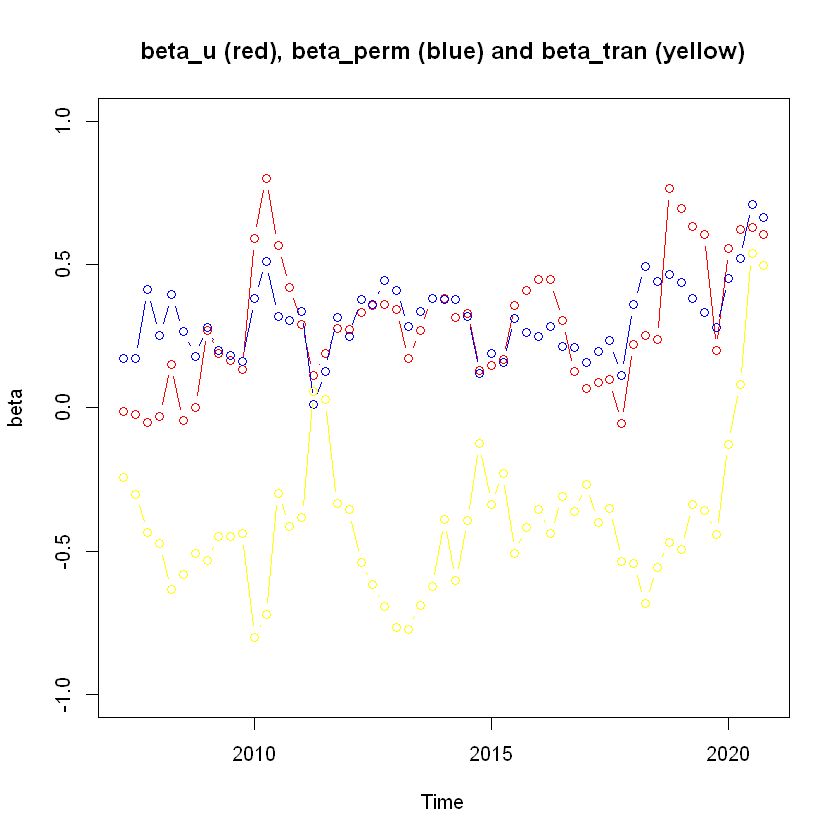

In [23]:
b.perm=c()
b.tran=c()
b.norm=c()
for(i in 4:58){
  reg.norm<-lm(con~factor(nat)+gdp,data = dta.p[dta.p$pit %in% (i-3):i,])
  b.norm[i-3]=reg.norm$coefficients['gdp']
  reg.perm<-lm(con~factor(nat)+gdp.p,data = dta.p[dta.p$pit %in% (i-3):i,])
  b.perm[i-3]=reg.perm$coefficients['gdp.p']
  reg.tran<-lm(con~factor(nat)+gdp.t,data = dta.p[dta.p$pit %in% (i-3):i,])
  b.tran[i-3]=reg.tran$coefficients['gdp.t']
}

plot(seq(as.Date("2007/4/1"), as.Date("2020/12/31"), by = "quarter"),b.norm,type='b',col='red',ylim=c(-1,1),xlab='Time',ylab='beta')
lines(seq(as.Date("2007/4/1"), as.Date("2020/12/31"), by = "quarter"),b.perm,type = 'b',col = 'blue')
lines(seq(as.Date("2007/4/1"), as.Date("2020/12/31"), by = "quarter"),b.tran,type = 'b',col='yellow')
title('beta_u (red), beta_perm (blue) and beta_tran (yellow)')

### Table 13: OLS: Disposable Income = country fixed effects + incidence + GDP component * stay home requirements * policy support

In [24]:
# stay home in perm component for europe # attenton difference between personal and disposable income

perm.sh<-lm(inc~factor(nat)+gdp.p*sh*ps+ic,data = dta.p.c)
tran.sh<-lm(inc~factor(nat)+gdp.t*sh*ps+ic,data = dta.p.c)
norm.sh<-lm(inc~factor(nat)+gdp*sh*ps+ic,data = dta.p.c)
totsh=coeftest(norm.sh,vcovCL,cluster=dta.p.c[,c('nat','year')])
persh=coeftest(perm.sh,vcovCL,cluster=dta.p.c[,c('nat','year')])
trash=coeftest(tran.sh,vcovCL,cluster=dta.p.c[,c('nat','year')])
rownames(persh)=rownames(totsh)
rownames(trash)=rownames(totsh)
stargazer(totsh,persh,trash,type = output,title = 'OLS: Disposable Income = country fixed effects + incidence + GDP component * stay home requirements * policy support',style = 'qje',omit = 'factor',omit.labels = ' Country fixed effects',column.labels = c('total','permanent','transitory'))



OLS: Disposable Income = country fixed effects + incidence + GDP component * stay home requirements * policy support
                                                              
                          total       permanent    transitory 
                           (1)           (2)          (3)     
--------------------------------------------------------------
gdp                     0.920***      0.519***       -0.243   
                         (0.249)       (0.044)      (0.234)   
                                                              
sh                        0.018        -0.018        -0.026   
                         (0.024)       (0.027)      (0.026)   
                                                              
ps                       0.0001*      0.0001***     0.00003   
                        (0.00004)     (0.00002)    (0.00004)  
                                                              
ic                      0.805***      0.633***      0.774***  


### Figure 12: constant expectation parameters vs breaks (a) \& (b)

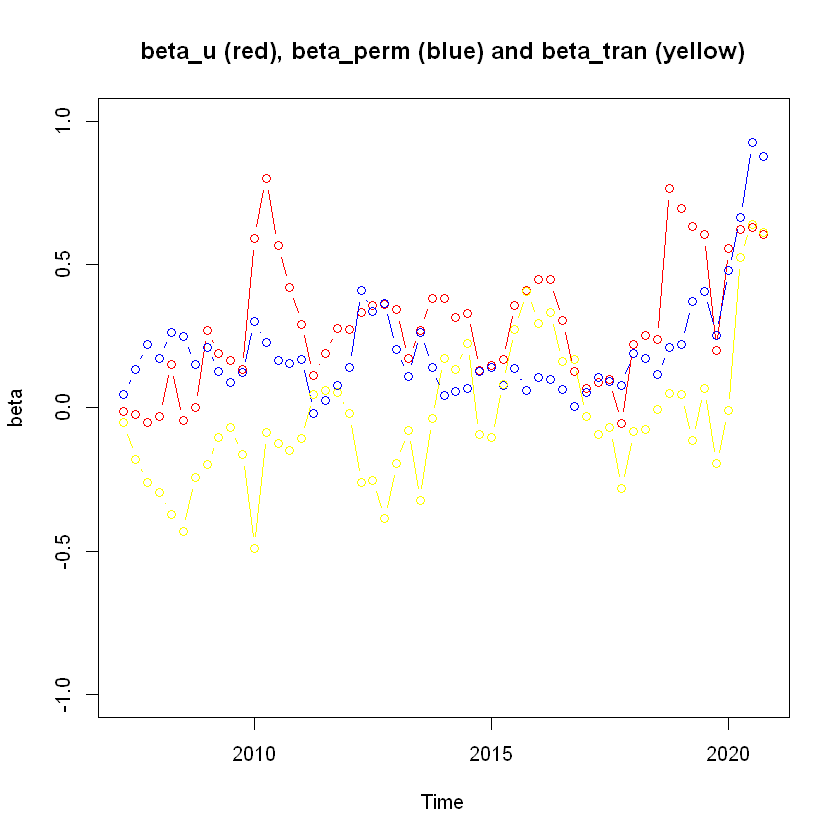

In [25]:
# VAR for different intervalls - 2013 break

s=2
e=30
for (z in 1:2) {

for (i in c(codes,'tot')){
  assign(paste('A',i,z,sep = '_'),Bcoef(VAR(window(get(paste('X',i,sep = '_')),start = s,end = e),type = 'none')))
}
s=s+29
e=e+30
}

################# actual calculation of perm gdp comp ########################

r=0.02

for (i in codes) {
  helper=NaN*(1:59)
  for (z in 1:59) {
    if(z>29){h=2}
    else(h=1) # decide which AR coefficients are used
    helper[z]=get(paste('l.gdp',i,sep='_'))[z+1]-l.gdp_tot[z+1]+E(get(paste('A',i,h,sep = '_')),get(paste('X',i,sep = '_'))[z,],r)
  }
assign(paste('gdp.p',i,sep='_'),diff(helper))
}
 
################ get data together in a data frame ###########################

t=length(get(paste('gdp.p',codes[1],sep='_')))
dta.p<-data.frame(pit=1:t,'nat'=rep(codes[1],t),'con'=diff(get(paste('l.con',codes[1],sep='_')))[-1]-diff(l.con_tot)[-1],'gdp.p'=get(paste('gdp.p',codes[1],sep='_')),'gdp'=diff(get(paste('l.gdp',codes[1],sep='_')))[-1]-diff(l.gdp_tot)[-1])

for (i in 2:obs) {
  tmp=data.frame(pit=1:t,'nat'=rep(codes[i],t),'con'=diff(get(paste('l.con',codes[i],sep='_')))[-1]-diff(l.con_tot)[-1],'gdp.p'=get(paste('gdp.p',codes[i],sep='_')),'gdp'=diff(get(paste('l.gdp',codes[i],sep='_')))[-1]-diff(l.gdp_tot)[-1])
  dta.p=rbind(dta.p,tmp)
}

dta.p$gdp.t=dta.p$gdp-dta.p$gdp.p

b.perm=c()
b.tran=c()
b.norm=c()
for(i in 4:58){
  reg.norm<-lm(con~factor(nat)+gdp,data = dta.p[dta.p$pit %in% (i-3):i,])
  b.norm[i-3]=reg.norm$coefficients['gdp']
  reg.perm<-lm(con~factor(nat)+gdp.p,data = dta.p[dta.p$pit %in% (i-3):i,])
  b.perm[i-3]=reg.perm$coefficients['gdp.p']
  reg.tran<-lm(con~factor(nat)+gdp.t,data = dta.p[dta.p$pit %in% (i-3):i,])
  b.tran[i-3]=reg.tran$coefficients['gdp.t']
}

plot(seq(as.Date("2007/4/1"), as.Date("2020/12/31"), by = "quarter"),b.norm,type='b',col='red',ylim=c(-1,1),xlab='Time',ylab='beta')
lines(seq(as.Date("2007/4/1"), as.Date("2020/12/31"), by = "quarter"),b.perm,type = 'b',col = 'blue')
lines(seq(as.Date("2007/4/1"), as.Date("2020/12/31"), by = "quarter"),b.tran,type = 'b',col='yellow')
title('beta_u (red), beta_perm (blue) and beta_tran (yellow)')

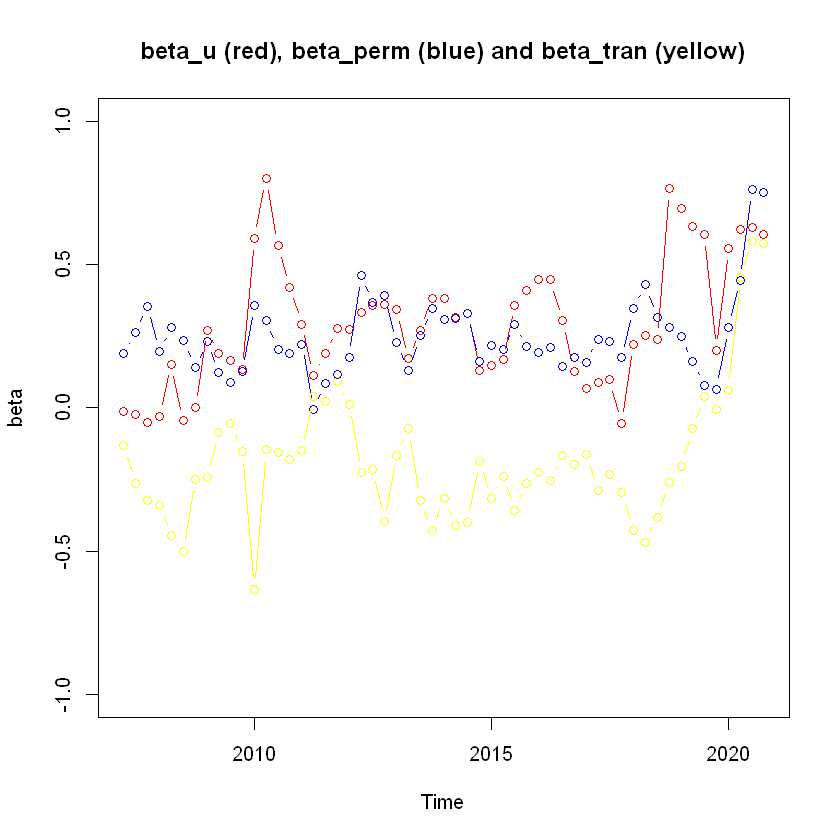

In [26]:
# VAR for different intervalls - 2018 break

s=2
e=50
for (z in 1:2) {
  
  for (i in c(codes,'tot')){
    assign(paste('A',i,z,sep = '_'),Bcoef(VAR(window(get(paste('X',i,sep = '_')),start = s,end = e),type = 'none')))
  }
  s=s+49
  e=e+10
}

################# actual calculation of perm gdp comp ########################

r=0.02

for (i in codes) {
  helper=NaN*(1:59)
  for (z in 1:59) {
    if(z>49){h=2}
    else(h=1) # decide which AR coefficients are used
    helper[z]=get(paste('l.gdp',i,sep='_'))[z+1]-l.gdp_tot[z+1]+E(get(paste('A',i,h,sep = '_')),get(paste('X',i,sep = '_'))[z,],r)
  }
  assign(paste('gdp.p',i,sep='_'),diff(helper))
}
 
################ get data together in a data frame ###########################

t=length(get(paste('gdp.p',codes[1],sep='_')))
dta.p<-data.frame(pit=1:t,'nat'=rep(codes[1],t),'con'=diff(get(paste('l.con',codes[1],sep='_')))[-1]-diff(l.con_tot)[-1],'gdp.p'=get(paste('gdp.p',codes[1],sep='_')),'gdp'=diff(get(paste('l.gdp',codes[1],sep='_')))[-1]-diff(l.gdp_tot)[-1])

for (i in 2:obs) {
  tmp=data.frame(pit=1:t,'nat'=rep(codes[i],t),'con'=diff(get(paste('l.con',codes[i],sep='_')))[-1]-diff(l.con_tot)[-1],'gdp.p'=get(paste('gdp.p',codes[i],sep='_')),'gdp'=diff(get(paste('l.gdp',codes[i],sep='_')))[-1]-diff(l.gdp_tot)[-1])
  dta.p=rbind(dta.p,tmp)
}

dta.p$gdp.t=dta.p$gdp-dta.p$gdp.p

b.perm=c()
b.tran=c()
b.norm=c()
for(i in 4:58){
  reg.norm<-lm(con~factor(nat)+gdp,data = dta.p[dta.p$pit %in% (i-3):i,])
  b.norm[i-3]=reg.norm$coefficients['gdp']
  reg.perm<-lm(con~factor(nat)+gdp.p,data = dta.p[dta.p$pit %in% (i-3):i,])
  b.perm[i-3]=reg.perm$coefficients['gdp.p']
  reg.tran<-lm(con~factor(nat)+gdp.t,data = dta.p[dta.p$pit %in% (i-3):i,])
  b.tran[i-3]=reg.tran$coefficients['gdp.t']
}

plot(seq(as.Date("2007/4/1"), as.Date("2020/12/31"), by = "quarter"),b.norm,type='b',col='red',ylim=c(-1,1),xlab='Time',ylab='beta')
lines(seq(as.Date("2007/4/1"), as.Date("2020/12/31"), by = "quarter"),b.perm,type = 'b',col = 'blue')
lines(seq(as.Date("2007/4/1"), as.Date("2020/12/31"), by = "quarter"),b.tran,type = 'b',col='yellow')
title('beta_u (red), beta_perm (blue) and beta_tran (yellow)')

### Figure 11: Permanent Component for year level data

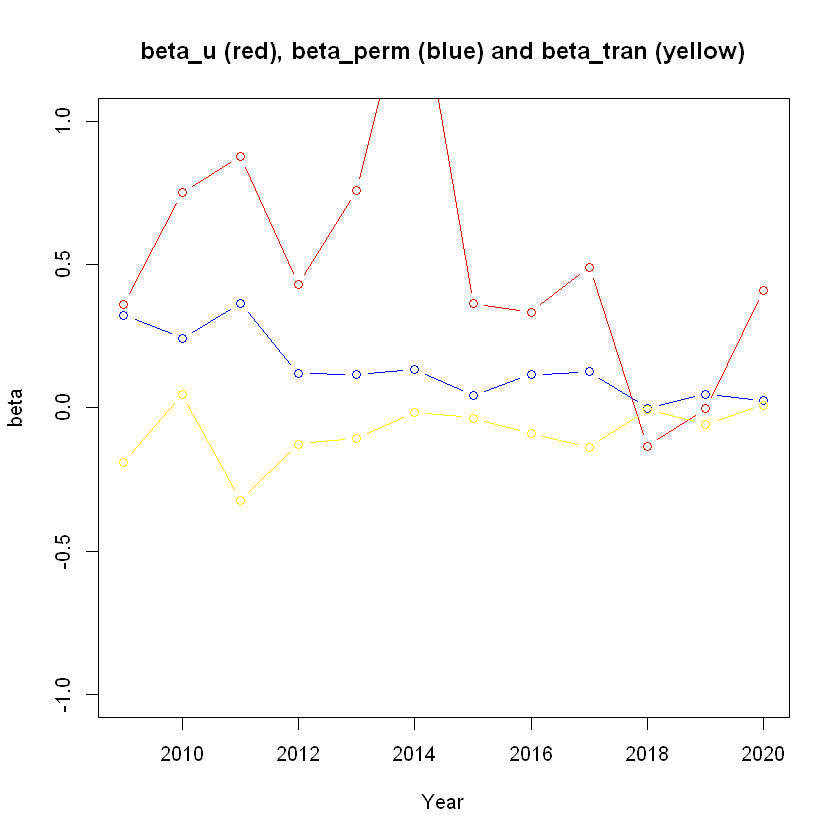

In [27]:
##########################################################################################
########################## get permanent component of annual gdp #########################
##########################################################################################

l.gdp_tot=rep(0,15)

for (i in codes) { # log gdp levels seasonal and calendar adjusted
  assign(paste("l.gdp",i,sep="_"),to.year(get(i)[get(i)$Indicator==row_gdp & is.na(get(i)$`Reference year`)==0,][2,][7:66]))
  l.gdp_tot=l.gdp_tot+get(paste("l.gdp",i,sep="_"))
  assign(paste("l.gdp",i,sep="_"),as.ts(log(get(paste("l.gdp",i,sep="_")))))
  assign(paste('ar',i,sep = '_'),arima(get(paste("l.gdp",i,sep="_")),order= c(1,1,0),include.mean = FALSE))
}

l.gdp_tot=as.ts(log(l.gdp_tot))
ar_tot=arima(l.gdp_tot,order = c(1,1,0),include.mean = FALSE  )


l.con_tot=rep(0,15)

for (i in codes) { # log con levels seasonal and calendar adjusted
  assign(paste("l.con",i,sep="_"),to.year(get(i)[get(i)$Indicator==row_con & is.na(get(i)$`Reference year`)==0,][2,][7:66]))
  l.con_tot=l.con_tot+get(paste("l.con",i,sep="_"))
  assign(paste("l.con",i,sep="_"),as.ts(log(get(paste("l.con",i,sep="_")))))
}

l.con_tot=as.ts(log(l.con_tot))


for (i in c(codes,'tot')){
  gdp=diff(get(paste("l.gdp",i,sep="_")))
  GDP=diff(l.gdp_tot)
  con=diff(get(paste("l.con",i,sep="_")))
  CON=diff(get(paste("l.con",i,sep="_"))-l.con_tot)
  
  assign(paste('X',i,sep = '_'),ts.intersect(gdp,GDP,CON))
}

for (i in c(codes,'tot')){
  assign(paste('A',i,sep = '_'),Bcoef(VAR(get(paste('X',i,sep = '_')),type = 'none')))
  assign(paste('a',i,sep = '_'),cbind(c(get(paste('ar',i,sep = '_'))$coef,0),c(0,ar_tot$coef)))
}

################# actual calculation of perm gdp comp ########################

r=0.02

for (i in codes) {
  helper=NaN*(1:14)
  for (z in 1:14) {
    helper[z]=get(paste('l.gdp',i,sep='_'))[z+1]-l.gdp_tot[z+1]+E(get(paste('A',i,sep = '_')),get(paste('X',i,sep = '_'))[z,],r)
  }
assign(paste('gdp.p',i,sep='_'),diff(helper))
}
 
################ get data together in a data frame ###########################

t=length(get(paste('gdp.p',codes[1],sep='_')))
dta.p<-data.frame(pit=1:t,'nat'=rep(codes[1],t),'con'=diff(get(paste('l.con',codes[1],sep='_')))[-1]-diff(l.con_tot)[-1],'gdp.p'=get(paste('gdp.p',codes[1],sep='_')),'gdp'=diff(get(paste('l.gdp',codes[1],sep='_')))[-1]-diff(l.gdp_tot)[-1])

for (i in 2:obs) {
  tmp=data.frame(pit=1:t,'nat'=rep(codes[i],t),'con'=diff(get(paste('l.con',codes[i],sep='_')))[-1]-diff(l.con_tot)[-1],'gdp.p'=get(paste('gdp.p',codes[i],sep='_')),'gdp'=diff(get(paste('l.gdp',codes[i],sep='_')))[-1]-diff(l.gdp_tot)[-1])
  dta.p=rbind(dta.p,tmp)
}

dta.p$gdp.t=dta.p$gdp-dta.p$gdp.p

############# developments over time #########################################

b.perm=c()
b.tran=c()
b.norm=c()
for(i in 2:13){
  reg.norm<-lm(con~factor(nat)+gdp,data = dta.p[dta.p$pit %in% (i-1):i,])
  b.norm[i-1]=reg.norm$coefficients['gdp']
  reg.perm<-lm(con~factor(nat)+gdp.p,data = dta.p[dta.p$pit %in% (i-1):i,])
  b.perm[i-1]=reg.perm$coefficients['gdp.p']
  reg.tran<-lm(con~factor(nat)+gdp.t,data = dta.p[dta.p$pit %in% (i-1):i,])
  b.tran[i-1]=reg.tran$coefficients['gdp.t']
}

plot(2009:2020,b.norm,type='b',col='red',ylim=c(-1,1),xlab='Year',ylab='beta')
lines(2009:2020,b.perm,type = 'b',col = 'blue')
lines(2009:2020,b.tran,type = 'b',col='yellow')
title('beta_u (red), beta_perm (blue) and beta_tran (yellow)')

### read in data - us sample

In [28]:
rm(list=setdiff(ls(),c('path','output',names(Filter(is.function, mget(ls(all=T)))))))
wls=1 # if =1 weighting by state polulation in 2020 ##user

In [29]:
# Oxford Covid-19 Government Response Tracker

mc_raw<-read_xlsx(paste(path,'MA_rep/OxCGRT_data/OxCGRTUS_timeseries_all','.xlsx',sep = ''),sheet = 1) # restrictions
ps_raw<-read_xlsx(paste(path,'MA_rep/OxCGRT_data/OxCGRTUS_timeseries_all','.xlsx',sep = ''),sheet = 4) # policy support
ic_raw<-read_xlsx(paste(path,'MA_rep/OxCGRT_data/OxCGRTUS_timeseries_all','.xlsx',sep = ''),sheet = 'confirmed_cases') # confirmed cases
mr_raw<-read_xlsx(paste(path,'MA_rep/OxCGRT_data/OxCGRTUS_timeseries_all','.xlsx',sep = ''),sheet = 'c7_movementrestrictions') # movement restrictions
sh_raw<-read_xlsx(paste(path,'MA_rep/OxCGRT_data/OxCGRTUS_timeseries_all','.xlsx',sep = ''),sheet = 'c6_stay_at_home_requirements') # stay at home requirements

# BEA population data 2020

pop_raw<-read.csv(paste(path,'MA_rep/bea_data/pop_bea2020.csv',sep=''),header=FALSE,stringsAsFactors = FALSE)

# BEA production and income data - quarterly on state-level

gsp_raw<-read.csv(paste(path,"MA_rep/bea_data/SQGDP9.csv",sep=''),header=FALSE,stringsAsFactors = FALSE)
inc_raw<-read.csv(paste(path,"MA_rep/bea_data/SQINC1.csv",sep=''),header=FALSE,stringsAsFactors = FALSE)[,-3]

### get 'tilde' variables and put everything together in a data frame

In [30]:
################################## state codes and names ####################################################

# excluding DC since cooks D suggests overproportional influence on coefficients

us_codes<-mc_raw$region_code[-8]
us_names<-mc_raw$region_name[-8]

################################## get quarterly means   ####################################################

cutoffs<-c('region_name','31Mar2020','30Jun2020','30Sep2020','31Dec2020')
# drop 2021 observations
mc_raw<-mc_raw[,-grep('2021',names(mc_raw))]
ps_raw<-ps_raw[,-grep('2021',names(ps_raw))]
mr_raw<-mr_raw[,-grep('2021',names(mr_raw))]
sh_raw<-sh_raw[,-grep('2021',names(sh_raw))]
ic_raw<-ic_raw[,names(ic_raw) %in% cutoffs]
ic_raw[,-(1:2)]<-ic_raw[,-(1:2)]-ic_raw[,-c(1,5)]

Q1=c('Jan','Feb','Mar')
Q2=c('Apr','May','Jun')
Q3=c('Jul','Aug','Sep')
Q4=c('Oct','Nov','Dec')


for(t in 1:4){
       assign(paste('mc_Q',t,sep = ''),cbind(us_names,rowMeans(mc_raw[,c(grep(get(paste('Q',t,sep = ''))[1],names(mc_raw)),grep(get(paste('Q',t,sep = ''))[2],names(mc_raw)),grep(get(paste('Q',t,sep = ''))[3],names(mc_raw)))])))
       assign(paste('ps_Q',t,sep = ''),cbind(us_names,rowMeans(ps_raw[,c(grep(get(paste('Q',t,sep = ''))[1],names(ps_raw)),grep(get(paste('Q',t,sep = ''))[2],names(ps_raw)),grep(get(paste('Q',t,sep = ''))[3],names(ps_raw)))])))
       assign(paste('mr_Q',t,sep = ''),cbind(us_names,rowMeans(mr_raw[,c(grep(get(paste('Q',t,sep = ''))[1],names(mr_raw)),grep(get(paste('Q',t,sep = ''))[2],names(mr_raw)),grep(get(paste('Q',t,sep = ''))[3],names(mr_raw)))]==2)))
       assign(paste('sh_Q',t,sep = ''),cbind(us_names,rowMeans(sh_raw[,c(grep(get(paste('Q',t,sep = ''))[1],names(sh_raw)),grep(get(paste('Q',t,sep = ''))[2],names(sh_raw)),grep(get(paste('Q',t,sep = ''))[3],names(sh_raw)))]>1)))
}

################################## get population weights                   ##################################

pop_raw<-pop_raw[pop_raw$V2 %in% us_names,c(2,6)]

################################## get 'tilde' values: difference to 'global' growth rate ####################

gsp_tilde=gsp_raw[gsp_raw$V2 %in% c('United States',us_names),-1]
inc_tilde=inc_raw[inc_raw$V2 %in% c('United States',us_names),-1]

gsp_tilde[-1,-1]=to.num(gsp_tilde[-1,-1])-matrix(rep(to.num(gsp_tilde[1,-1]),length(gsp_tilde$V2)-1),nrow = length(gsp_tilde$V2)-1,byrow = TRUE)
inc_tilde[-1,-1]=to.num(inc_tilde[-1,-1])-matrix(rep(to.num(inc_tilde[1,-1]),length(inc_tilde$V2)-1),nrow = length(inc_tilde$V2)-1,byrow = TRUE)

################################# prepare a data frame #######################################################

dta.us<-data.frame('state'=rep(us_names,each=63),'pit'=rep(1:63,length(us_names)))
dta.us$year=year(dta.us$pit,start = 2005,sq=1)
dta.us$gsp=0
dta.us$inc=0
dta.us$mc=0
dta.us$ps=0
dta.us$pop=0
dta.us$ic=0
dta.us$mr=0
dta.us$sh=0

################################# fill data frame     ########################################################

for (r in 1:nrow(dta.us)) {
  state=dta.us$state[r]
  pit=dta.us$pit[r]
  
  dta.us$gsp[r]=gsp_tilde[gsp_tilde[,1]==state,pit+1]
  dta.us$inc[r]=inc_tilde[inc_tilde[,1]==state,pit+1]
  dta.us$pop[r]=pop_raw[pop_raw[,1]==state,2]
  
  if(pit>=60){dta.us$mc[r]=get(paste('mc_Q',pit-59,sep = ''))[get(paste('mc_Q',pit-59,sep = ''))[,1]==state,2]
              dta.us$ps[r]=get(paste('ps_Q',pit-59,sep = ''))[get(paste('ps_Q',pit-59,sep = ''))[,1]==state,2]
              dta.us$mr[r]=get(paste('mr_Q',pit-59,sep = ''))[get(paste('mr_Q',pit-59,sep = ''))[,1]==state,2]
              dta.us$sh[r]=get(paste('sh_Q',pit-59,sep = ''))[get(paste('sh_Q',pit-59,sep = ''))[,1]==state,2]
              dta.us$ic[r]=ic_raw[c(ic_raw[,1])$region_name==toString(state),pit-59+1]/as.numeric(dta.us$pop[r])
    }
}

############################### make sure type of vars ins as desired ########################################

dta.us$gsp=as.numeric(dta.us$gsp)/100
dta.us$inc=as.numeric(dta.us$inc)/100
dta.us$mc=as.numeric(dta.us$mc)
dta.us$ps=as.numeric(dta.us$ps)
dta.us$pop=as.numeric(dta.us$pop)
dta.us$ic=as.numeric(dta.us$ic)
dta.us$mr=as.numeric(dta.us$mr)
dta.us$sh=as.numeric(dta.us$sh)

############################### option to do wls/ols #########################################################

if(wls==0){
  dta.us$pop=1
}

# show head of 2020 subset of df

head(dta.us[dta.us$year==2020,])

,state,pit,year,gsp,inc,mc,ps,pop,ic,mr,sh
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
60,Alaska,60,2020,-0.010,-0.044,22.68209,10.71429,730138,0.0001766789,0.04395604,0.10989011
61,Alaska,61,2020,-0.024,-0.043,70.34022,87.50000,730138,0.0013874090,0.51648352,0.25274725
62,Alaska,62,2020,-0.012,-0.056,57.54359,70.65217,730138,0.0105514300,0.84782609,0.00000000
63,Alaska,63,2020,0.015,-0.011,59.14022,49.72826,730138,0.0522750494,1.00000000,0.00000000
123,Alabama,60,2020,0.018,0.018,14.91253,5.21978,4928670,0.0002156768,0.00000000,0.08791209
124,Alabama,61,2020,0.018,0.053,65.89747,62.50000,4928670,0.0075910946,0.00000000,0.87912088


### Table 10: WLS: Personal Income = state fixed effects + incidence + GSP * travel restrictions * policy support

In [31]:
travel.reg=glm(inc~factor(state)+ic+gsp*ps*mr,data = dta.us,weights=dta.us$pop)
stargazer(coeftest(travel.reg,vcovCL,cluster=dta.us[,c('state','year')]),type = output,title = 'WLS: Personal Income = state fixed effects + incidence + GSP * travel restrictions * policy support',style = 'qje',omit = 'factor',omit.labels = ' State fixed effects')


WLS: Personal Income = state fixed effects + incidence + GSP * travel restrictions * policy support
                                                          
----------------------------------------------------------
ic                                 0.451***               
                                   (0.047)                
                                                          
gsp                                0.497***               
                                   (0.028)                
                                                          
ps                                -0.0002***              
                                  (0.00003)               
                                                          
mr                                -0.062***               
                                   (0.008)                
                                                          
gsp:ps                            -0.014***               
              

### Table 11: WLS: Personal Income = state fixed effects + incidence + GSP * stay at home requirements * policy support

In [32]:
home.reg=glm(inc~factor(state)+ic+gsp*ps*sh,data = dta.us,weights=dta.us$pop)
stargazer(coeftest(home.reg,vcovCL,cluster=dta.us[,c('state','year')]),type = output,title = 'WLS: Personal Income = state fixed effects + incidence + GSP * stay at home requirements * policy support',style = 'qje',omit = 'factor',omit.labels = ' State fixed effects')


WLS: Personal Income = state fixed effects + incidence + GSP * stay at home requirements * policy support
                                                          
----------------------------------------------------------
ic                                 0.421***               
                                   (0.048)                
                                                          
gsp                                0.496***               
                                   (0.028)                
                                                          
ps                                -0.0002***              
                                  (0.00003)               
                                                          
sh                                -0.015***               
                                   (0.004)                
                                                          
gsp:ps                            -0.013***               
        

In [33]:
# look for assymetrics, not in thesis but might interesting

dta.us$up=dta.us$gsp>0

asym<-lm(inc~factor(state)+ic+gsp*up,data = dta.us)
stargazer(coeftest(asym,vcovCL,cluster=dta.us[,c('state','year')]),type = output,title = 'Triple interaction regression: Consumption - asym?',style = 'qje',omit = 'factor',omit.labels = ' Country fixed effects')


Triple interaction regression: Consumption - asym?
                                                            
------------------------------------------------------------
ic                                   0.581***               
                                     (0.036)                
                                                            
gsp                                  0.476***               
                                     (0.062)                
                                                            
up                                    0.004                 
                                     (0.003)                
                                                            
gsp:up                              -0.121***               
                                     (0.037)                
                                                            
Constant                              -0.003                
                                 

### calculate permanent and transitory component and add them to data frame

In [34]:
##########################################################################################
########################## get permanent component of gsp ################################
##########################################################################################

inc_ste=inc_raw[-c(1:5,66:69),-1]
gsp_ste=gsp_raw[-c(1:5,66:68),-1]

for (i in us_names){
  gsp=as.numeric(gsp_ste[gsp_ste[,1]==i,-1])
  GSP=as.numeric(gsp_ste[gsp_ste[,1]=='United States',-1])
  INC=as.numeric(inc_ste[inc_ste[,1]==i,-1])-as.numeric(inc_ste[inc_ste[,1]=='United States',-1])
  assign(paste('X',i,sep = '_'),ts(cbind(gsp,GSP,INC)/100))
}

for (i in c(us_names)){
  assign(paste('A',i,sep = '_'),Bcoef(VAR(get(paste('X',i,sep = '_')),type = 'none')))
}

################# actual calculation of perm gsp comp ########################

r=0.02

for (i in us_names) {
  helper=NaN*(1:63)
  for (z in 1:63) {
    helper[z]=E(get(paste('A',i,sep = '_')),get(paste('X',i,sep = '_'))[z,],r)
  }
assign(paste('dif.p',i,sep='_'),diff(helper))
}
 
################ add perm gsp component in the data frame #####################

dta.us.p=dta.us[dta.us$pit!=1,]

dta.us.p$gsp.perm=NA

for (i in us_names) {
  dta.us.p$gsp.perm[dta.us.p$state==i]=dta.us.p$gsp[dta.us.p$state==i]+get(paste('dif.p',i,sep='_'))
}

dta.us.p$gsp.tran<-dta.us.p$gsp-dta.us.p$gsp.perm

# show head of 2020 subset of df

head(dta.us.p[dta.us.p$year==2020,])

,state,pit,year,gsp,inc,mc,ps,pop,ic,mr,sh,up,gsp.perm,gsp.tran
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>
60,Alaska,60,2020,-0.010,-0.044,22.68209,10.71429,730138,0.0001766789,0.04395604,0.10989011,FALSE,0.006199911,-0.016199911
61,Alaska,61,2020,-0.024,-0.043,70.34022,87.50000,730138,0.0013874090,0.51648352,0.25274725,FALSE,-0.031386525,0.007386525
62,Alaska,62,2020,-0.012,-0.056,57.54359,70.65217,730138,0.0105514300,0.84782609,0.00000000,FALSE,-0.013797871,0.001797871
63,Alaska,63,2020,0.015,-0.011,59.14022,49.72826,730138,0.0522750494,1.00000000,0.00000000,TRUE,0.045865587,-0.030865587
123,Alabama,60,2020,0.018,0.018,14.91253,5.21978,4928670,0.0002156768,0.00000000,0.08791209,TRUE,0.023607856,-0.005607856
124,Alabama,61,2020,0.018,0.053,65.89747,62.50000,4928670,0.0075910946,0.00000000,0.87912088,TRUE,0.032438315,-0.014438315


### Table 12: WLS: Personal Income = state fixed effects + incidence + GDP component * stay at home requirements * policy support

In [35]:
normreg.sh=glm(inc~factor(state)+ic+gsp*ps*sh,data = dta.us.p,weights=dta.us.p$pop)
permreg.sh=glm(inc~factor(state)+ic+gsp.perm*ps*sh,data = dta.us.p,weights=dta.us.p$pop)
tranreg.sh=glm(inc~factor(state)+ic+gsp.tran*ps*sh,data = dta.us.p,weights=dta.us.p$pop)
totus=coeftest(normreg.sh,vcovCL,cluster=dta.us.p[,c('state','year')])
perus=coeftest(permreg.sh,vcovCL,cluster=dta.us.p[,c('state','year')])
traus=coeftest(tranreg.sh,vcovCL,cluster=dta.us.p[,c('state','year')])
rownames(perus)=rownames(totus)
rownames(traus)=rownames(totus)
stargazer(totus,perus,traus,type=output,title = 'WLS: Personal Income = state fixed effects + incidence + GDP component * stay at home requirements * policy support',style = 'qje',omit = 'factor',omit.labels = ' State fixed effects',column.labels = c('total','permanent','transitory'))


WLS: Personal Income = state fixed effects + incidence + GDP component * stay at home requirements * policy support
                                                            
                        total       permanent    transitory 
                         (1)           (2)          (3)     
------------------------------------------------------------
ic                    0.422***      0.451***      0.525***  
                       (0.048)       (0.047)      (0.020)   
                                                            
gsp                   0.497***      0.366***       0.194    
                       (0.027)       (0.034)      (0.167)   
                                                            
ps                   -0.0002***    -0.0003***    -0.0002*** 
                      (0.00003)     (0.00003)    (0.00002)  
                                                            
sh                    -0.015***       0.011        -0.007   
                       (0.004

## End of empirical part - Beginning of theoretical part

In [36]:
rm(list=ls())
options(warn=-1)

### Figure 2: Illustration of the implications of different degrees of risk sharing under various circumstances

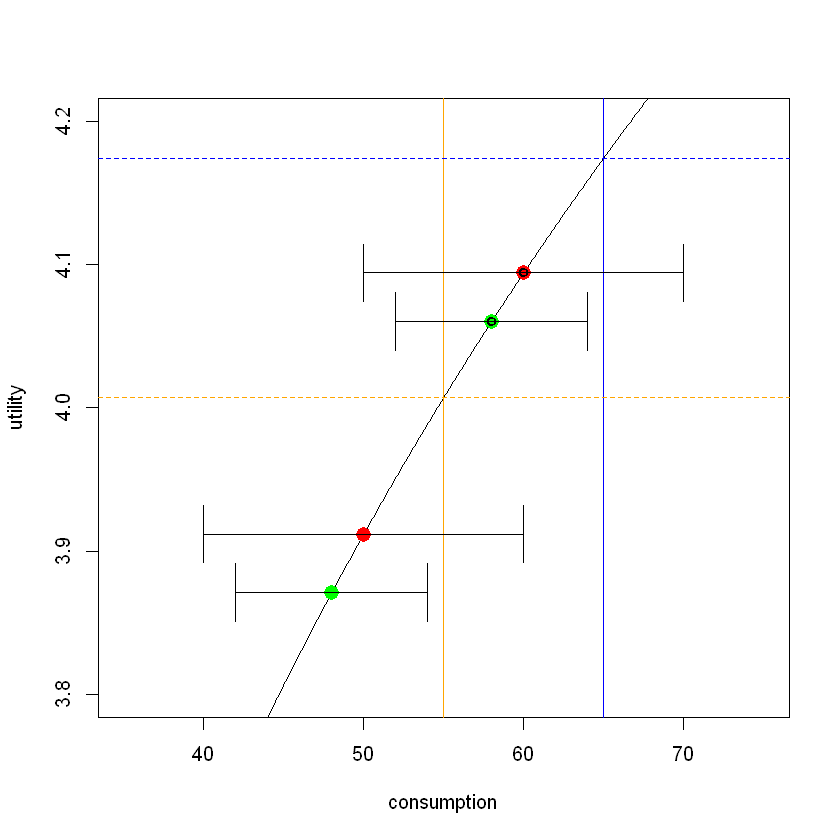

In [37]:
util<-function(x){
  return(log(x))
}

consumption<-seq(1,400,0.1)
utility<-sapply(consumption,util)
plot(consumption,utility,type = 'l',xlim = c(35,75),ylim = c(3.8,4.2))
abline(v=55,col='orange')
abline(v=65,col='blue')
abline(h=util(55),col='orange',lty='dashed')
abline(h=util(65),col='blue',lty='dashed')
lines(c(50,60),util(c(50,60)),type = 'p',col='red',lwd=6)
lines(c(40,60),c(util(50),util(50)))
lines(c(50,70),c(util(60),util(60)))
lines(c(70,70),c(util(60)-0.02,util(60)+0.02))
lines(c(50,50),c(util(60)-0.02,util(60)+0.02))
lines(c(40,40),c(util(50)-0.02,util(50)+0.02))
lines(c(60,60),c(util(50)-0.02,util(50)+0.02))

lines(c(48,58),util(c(48,58)),type = 'p',col='green',lwd=6)
lines(c(42,54),c(util(48),util(48)))
lines(c(52,64),c(util(58),util(58)))
lines(c(64,64),c(util(58)-0.02,util(58)+0.02))
lines(c(52,52),c(util(58)-0.02,util(58)+0.02))
lines(c(42,42),c(util(48)-0.02,util(48)+0.02))
lines(c(54,54),c(util(48)-0.02,util(48)+0.02))

lines(c(58,60),log(c(58,60)),type = 'p',lwd=2)

### Figure 3: Expected utility implied by different degrees of risk sharing

In [38]:
###########################################################################################################################################
###################### discrete choice problem for risk sharing in presence of consumption cap and transfer ###############################
###########################################################################################################################################

# utility function

util<-function(c,mc=999){
  log(min(c,mc))
}

scenario<-function(mc=999,ps=0,p=0.5)
{
# set seed and # simulated incomes

set.seed(123)
g=10000

# set exogeneous variables

mc=mc#40            # consumption restrictive measures - lower = stricter 
ps=ps#15            # transfer compensation for covid related losses

ep=35               # mean / expected production
sd=8                # standard deviation of production

cf=2                # standard deviation of common factor

p=p                 # price of full risk sharing compared to autarky (linear)

# simulate income for A and B (two ex ante identical countries)

com<-rnorm(g,0,cf)

y_a<-rnorm(g,ep,sd)+com
sd(y_a)

y_b<-rnorm(g,ep,sd)+com
sd(y_b)

y_s<-(y_a+y_b)/2
sd(y_s)

# grid for possible degrees of risk sharing (0 no risk sharing at all 1 full risk sharing)

k<-seq(0,1,0.01)

# simulation of resulting utility for different degrees of risk sharing - small economies (-> price takers) 
# assuming that a priori countries take each realisation of income as equally likely we can simulate expectations by taking means across realizations

UA=matrix(nrow = g,ncol = 101)
for (i in 1:g) {
 ua<-sapply(k*y_s[i]+(1-k)*y_a[i]+ps-k*p, util,mc=mc) 
 UA[i,]=ua
}
res_a=colMeans(UA)
plot(res_a,type='l',ylab = 'exp. utility',xlab = '% of shared risk')

UB=matrix(nrow = g,ncol = 101)
for (i in 1:g) {
  ub<-sapply(k*y_s[i]+(1-k)*y_b[i]+ps-k*p, util,mc=mc) 
  UB[i,]=ub
}
res_b=colMeans(UB)
plot(res_b,ylab = 'exp. utility',xlab = '% of shared risk')
}

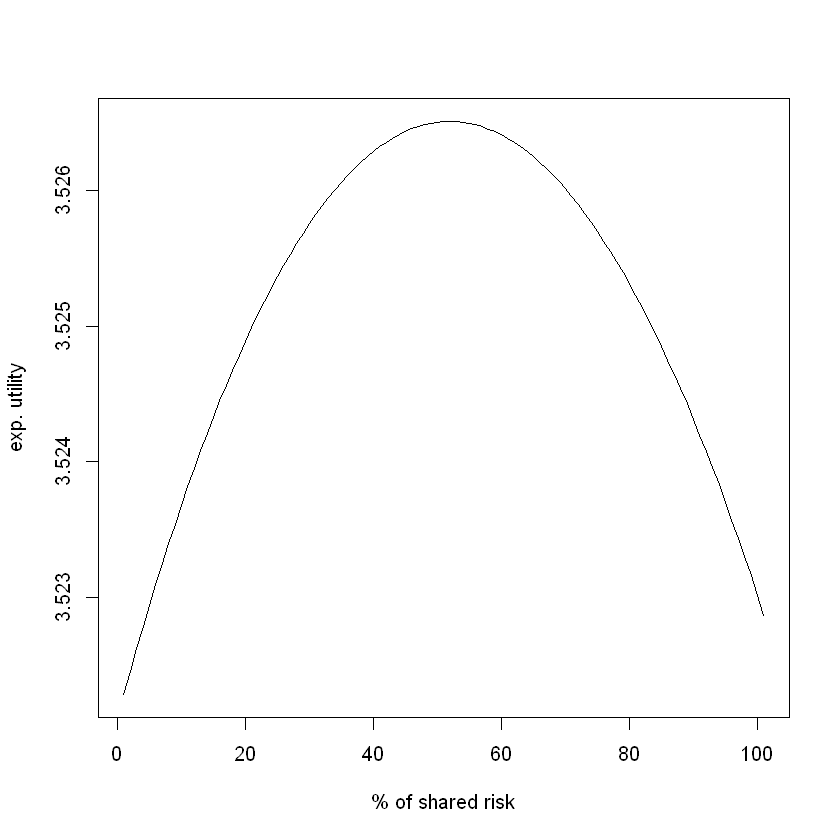

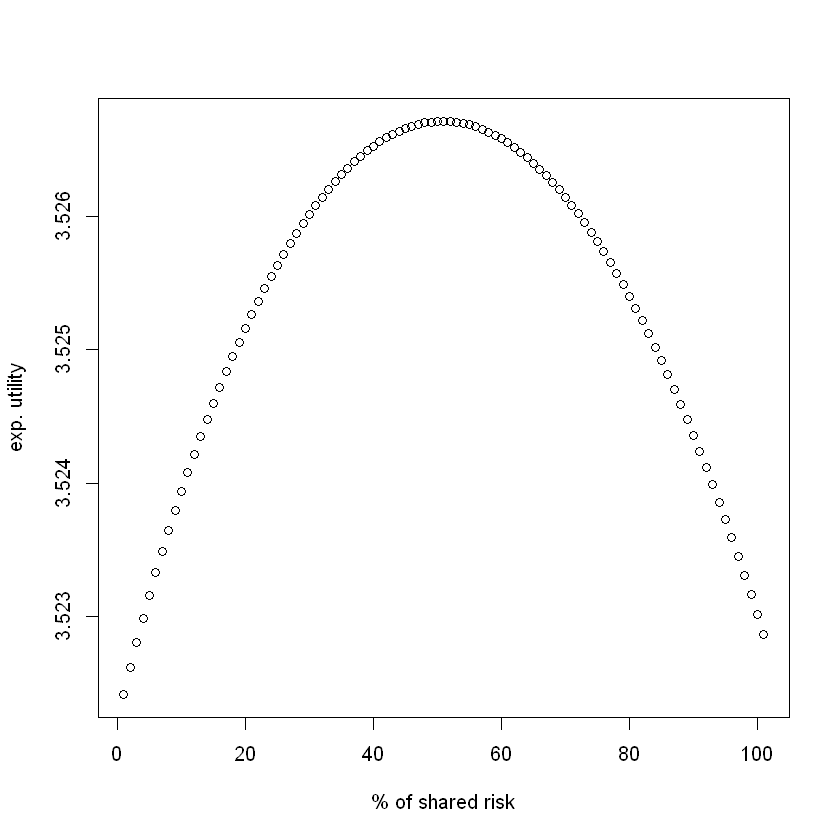

In [39]:
# basecase
scenario()

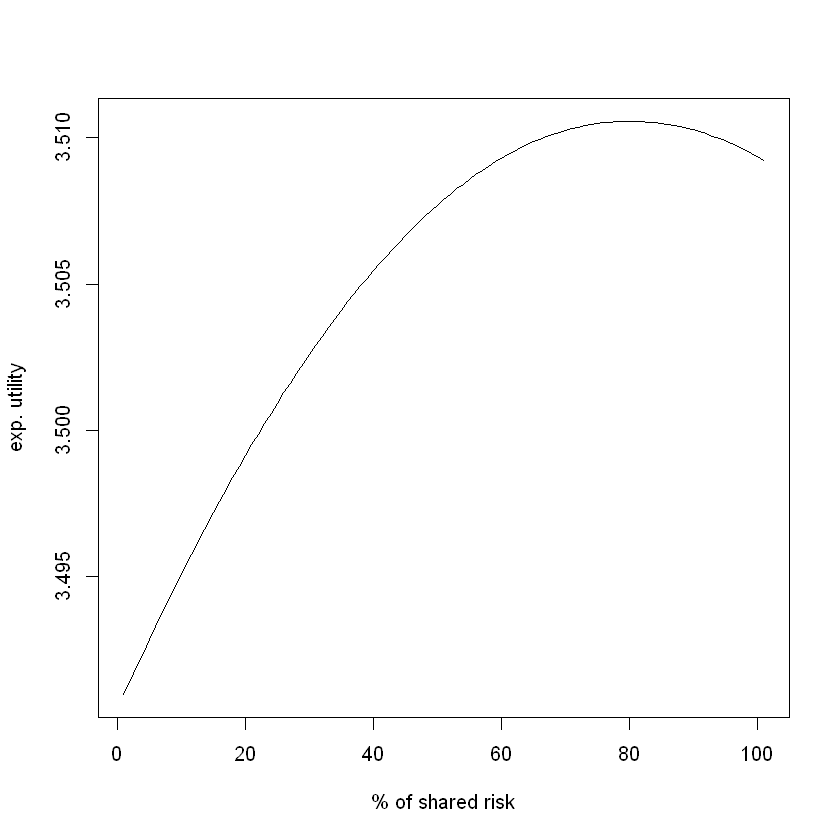

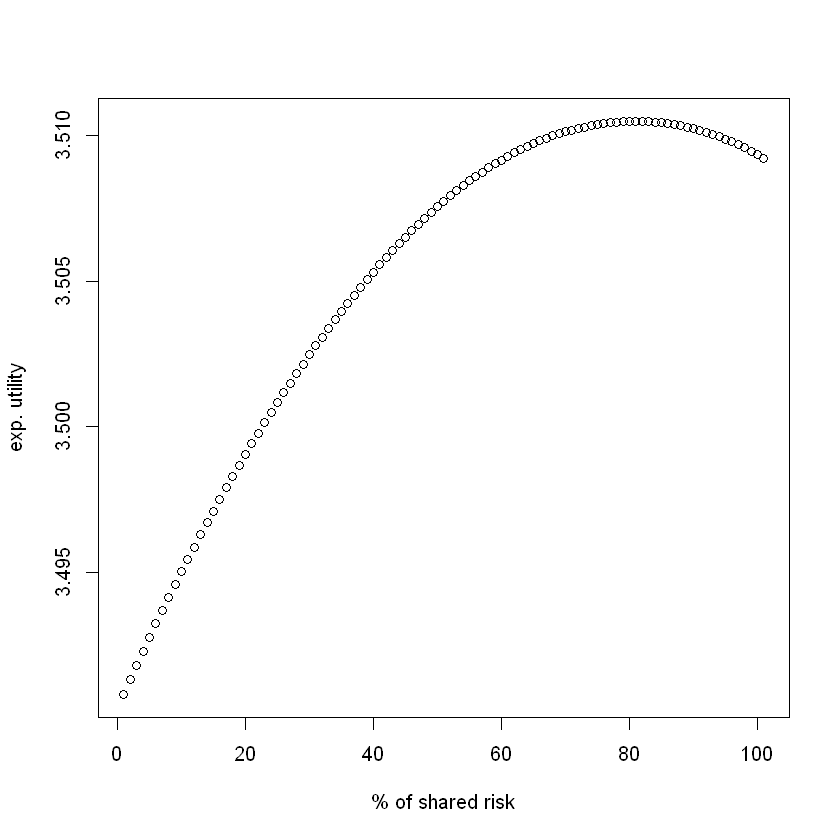

In [40]:
# restrictive measures
scenario(mc=40)

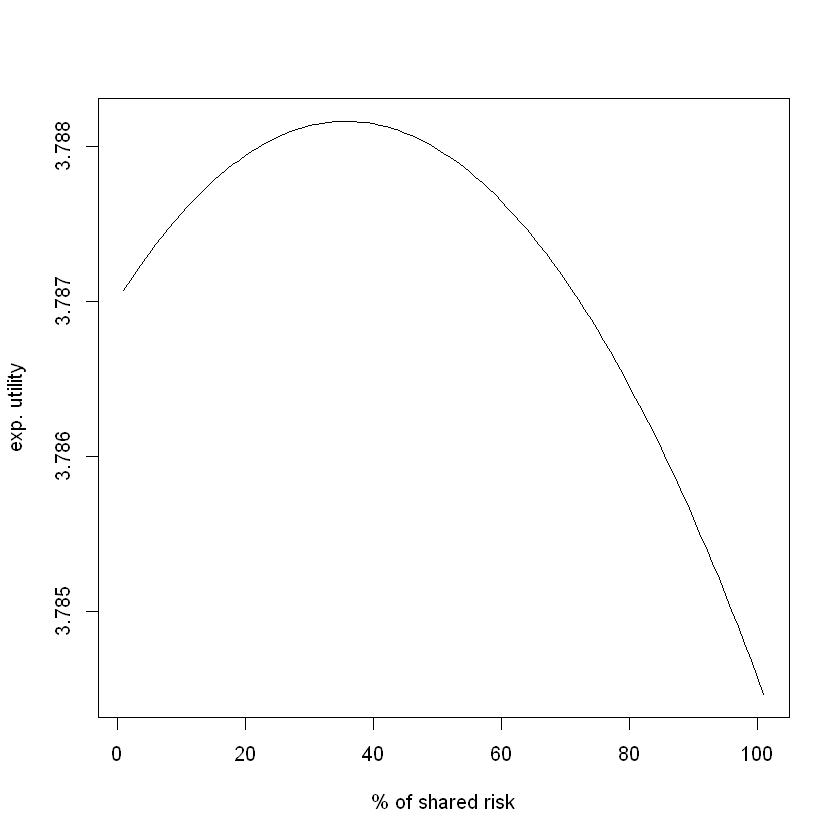

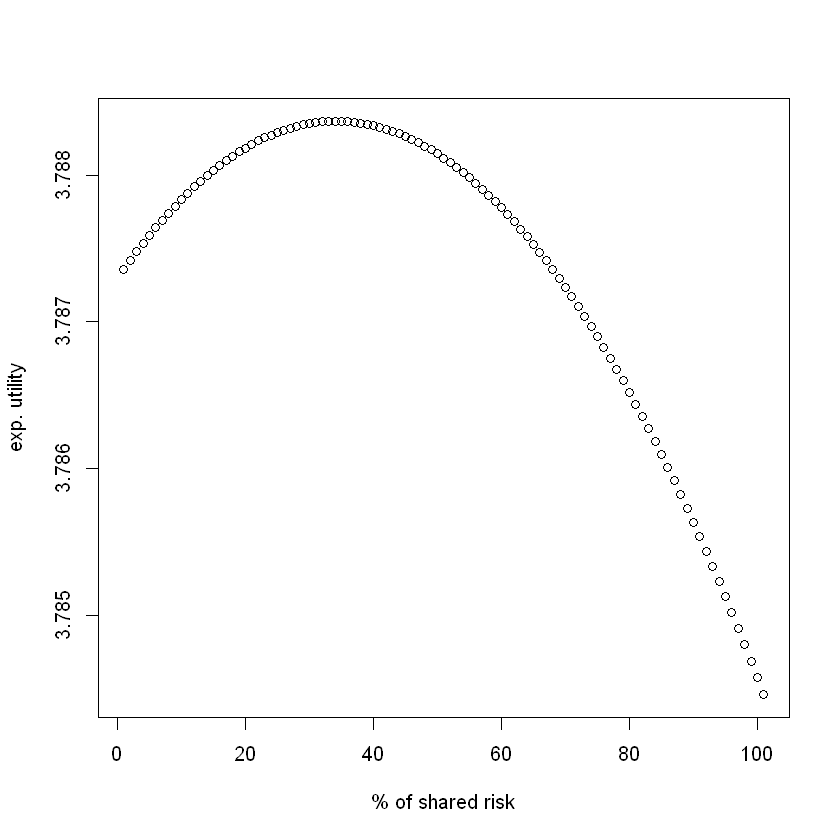

In [41]:
# policy support
scenario(ps=10)

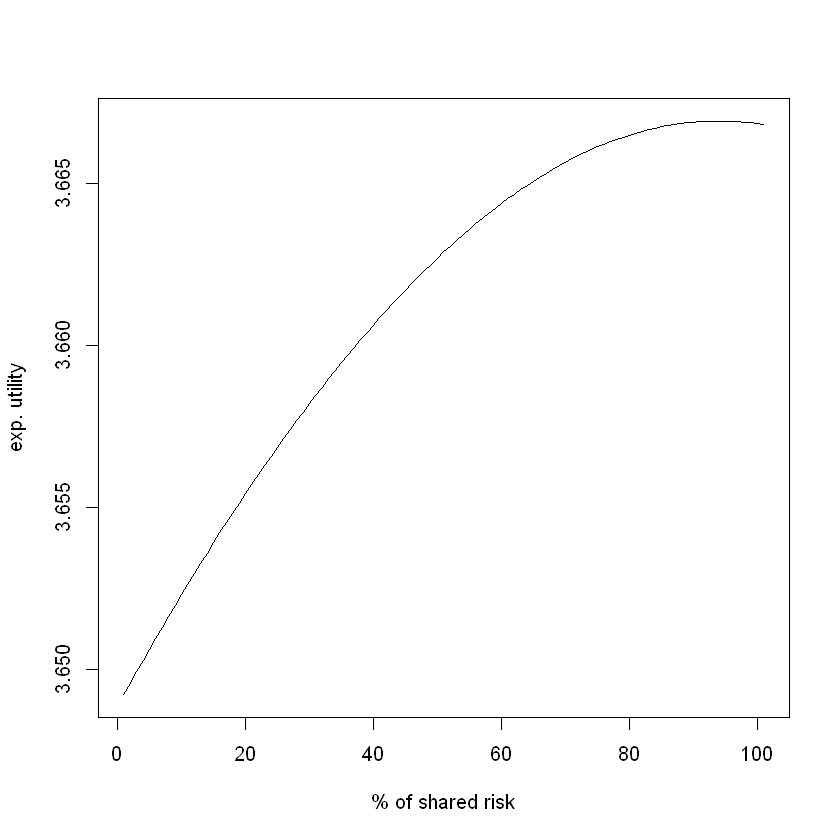

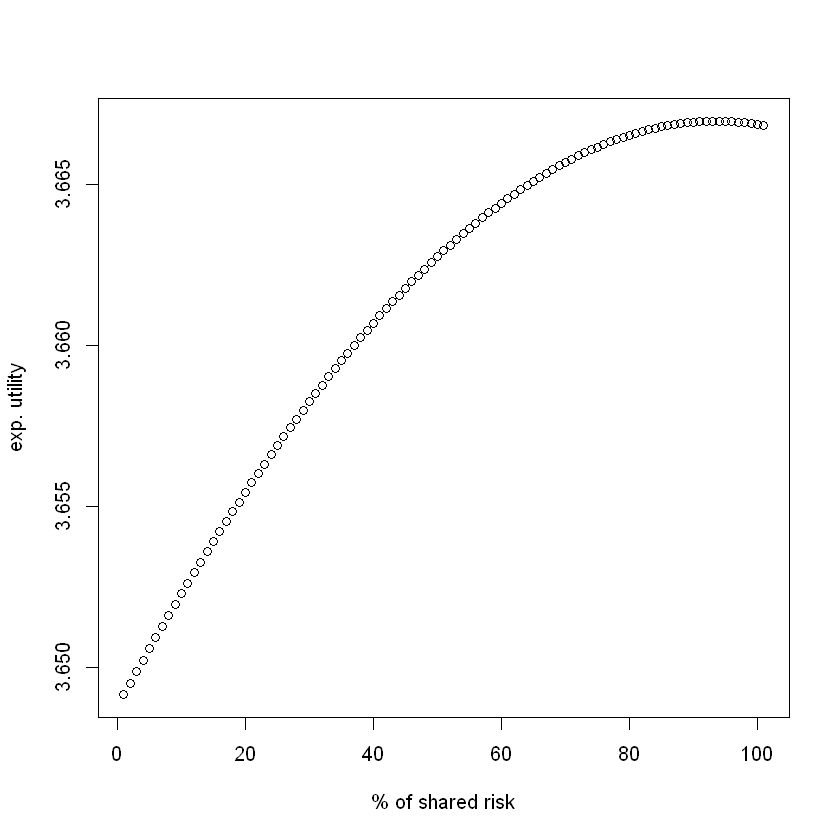

In [42]:
# interaction of policy support and restrictive measures
scenario(ps=10,mc=40)